# Both Active-and/or-Substantial Incubator Projects and Incubator Graduates: Incubator History Visualizations

This notebook provides visualizations of Incubator edit data trends for 
* projects that have graduated from Incubator, and 
* Active-and/or-Substantial Incubator Projects that have not yet graduated.

Per [Wikimedia Incubator](https://incubator.wikimedia.org/wiki/Incubator:Wikis): test wikis are "**substantial**" if they have "at least 25 mainspace pages"; test wikis are "**active**" if they have had "some active content creation since the beginning of 2023". The latter has been interpreted to mean the test wiki had at least 1 new page created in the mainspace since the beginning of 2023.

## Load packages

In [ ]:
library(tidyverse)
library(plyr)
library(viridis) # for accessible colors
library(pollster) # for crosstabbing
library(here)
here()

## Load data

In [2]:
# Run this to ensure all wrangled data files are up-to-date. Skip if already done so in another notebook recently.

## Run all cells of notebook
#pycmd <- "python -m jupyter nbconvert --ExecutePreprocessor.timeout=None --to notebook --execute ../../02_wrangling_scripts/wrangle_final.ipynb"
#cat(pycmd)

## Execute command to run another notebook (in this case load_dataframe_for_analysis.ipynb)
## This will update the TSV outputs from that notebook, which will be loaded into this notebook in the cells below
#system(pycmd, intern = TRUE) #### update with names

## FYI: this will take a long time to run, because it's running 7 notebooks, some of which include spark queries ~~~~
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# Load data for Incubator graduates
df <- read_tsv(here::here("03_wrangled_data/incubator_graduates_firstlast_edits.tsv"))  %>%
  select(-`...1`)

# Wrangle (remove word "days")
df$grads_total_days_in_incubator <- gsub(" days", "", df$grads_total_days_in_incubator)
df$grads_total_days_in_incubator <- as.numeric(df$grads_total_days_in_incubator)
df$diff_last_and_grad <- gsub(" days", "", df$diff_last_and_grad)
df$diff_last_and_grad <- as.numeric(df$diff_last_and_grad)

In [4]:
head(df)

prefix grad_dt    source   language_name grads_mean_last_edit_5percent
1 Wb/ba  2017-08-21 Graduate Bashkir       2017-08-17                   
2 Wb/li  2010-11-13 Graduate Limburgish    2010-11-04                   
3 Wb/shn 2023-01-04 Graduate Shan          2022-10-19                   
4 Wn/cs  2008-05-26 Graduate Czech         2008-02-04                   
5 Wn/el  2011-04-09 Graduate Greek         2011-04-01                   
6 Wn/eo  2010-11-13 Graduate Esperanto     2010-11-04                   
  first_edit_dt grads_mean_initial_date_5percent grads_total_days_in_incubator
1 2009-01-08    2009-01-08                       3147                         
2 2008-07-30    2008-07-30                        836                         
3 2021-09-21    2021-09-21                        470                         
4 2008-02-04    2008-02-04                        112                         
5 2009-03-13    2009-03-13                        757                         
6 2010-03-18    2010-03-18                        240                         
  diff_last_and_grad project  
1   4                Wikibooks
2   9                Wikibooks
3  77                Wikibooks
4 112                Wikinews 
5   8                Wikinews 
6   9                Wikinews

In [ ]:
# Load language data
langs <- read_tsv(here::here("03_wrangled_data/project_languages.tsv")) 

In [ ]:
# Load data for current Incubator projects
df_c_import <- read_tsv(here::here("03_wrangled_data/current_incubator_firstlast_edits.tsv"))

# Load substantial and active inc project lists
substantial_import <- read_tsv(here("03_wrangled_data/incubator_substantial_projects.tsv"))
active_import <- read_tsv(here("03_wrangled_data/incubator_active_projects.tsv"))

# Merge substantial and active denotations with current Incubator project df, and then
# filter for active and/or substantial only
df_c <- df_c_import %>% 
  full_join(., (substantial_import %>% select(prefix) %>% mutate(substantial="Yes")), by="prefix")%>% 
  full_join(., (active_import %>% select(prefix) %>% mutate(active="Yes")), by="prefix") %>%
  filter(active=="Yes"|substantial=="Yes")

## Analysis of current and graduated Incubator projects' graduation rates

In [7]:
options(repr.plot.width=16, repr.plot.height=08)

In [8]:
## PREP: GRADUATED INC PROJECTS' TIME IN INCUBATOR

## gather dates per type; then additional wrangling
first_to_grad <- df %>%
  mutate(first_edit_dt_copy = first_edit_dt) %>%
  gather(., key = "date_type", value = "date", c(first_edit_dt_copy, grad_dt)) %>%
  mutate(current_dt = NA) %>% # add dummy for binding
  mutate(days_since_started = NA) %>% # add dummy for binding
  mutate(grad_yn = "Yes") %>% # denote grad 
  mutate(first_edit_year = format(as.Date(first_edit_dt, format="%d/%m/%Y"),"%Y")) %>% # denote first edit year
  mutate(weight=1) %>% # add dummy weight for crosstabbing with pollster
  select(prefix, language_name, project, first_edit_dt, first_edit_year, date, date_type, 
         grads_total_days_in_incubator, days_since_started, current_dt, grad_yn, weight) %>% # order for binding
  dplyr::rename(grads_total_days_in_incubator_if_grad = grads_total_days_in_incubator) # rename variable for clarity

In [9]:
## PREP: CURRENT INC PROJECTS' TIME IN INCUBATOR

## gather dates per type; then additional wrangling
first_to_current <- df_c %>%
  mutate(first_edit_dt_copy = first_edit_dt) %>%
  mutate(current_dt_copy = current_dt) %>%
  gather(., key = "date_type", value = "date", c(first_edit_dt_copy, current_dt_copy)) %>%
  mutate(grads_total_days_in_incubator = NA) %>% # add dummy for binding
  mutate(days_since_started = current_dt - first_edit_dt) %>% # calculate days since started
  mutate(grad_yn = "No") %>% # denote not grad 
  mutate(first_edit_year = format(as.Date(first_edit_dt, format="%d/%m/%Y"),"%Y")) %>% # denote first edit year
  mutate(weight=1) %>% # add dummy weight for crosstabbing with pollster
  select(prefix, language_name, project, first_edit_dt, first_edit_year, date, date_type, 
         grads_total_days_in_incubator, days_since_started, current_dt, grad_yn, weight) # order for binding

## clarify column name meaning
first_to_current <- first_to_current %>%
  dplyr::rename(grads_total_days_in_incubator_if_grad = grads_total_days_in_incubator) # for future clarity

In [10]:
## BIND PREVIOUS 2 DFs
first_to_grad_or_current <- rbind(first_to_current, first_to_grad)

## shorten df name
ftgoc <- first_to_grad_or_current
head(ftgoc)

prefix language_name   project   first_edit_dt first_edit_year date      
1 Wb/ace Achinese        Wikibooks 2023-07-30    2023            2023-07-30
2 Wb/ady Adyghe          Wikibooks 2023-03-13    2023            2023-03-13
3 Wb/arz Egyptian Arabic Wikibooks 2019-08-18    2019            2019-08-18
4 Wb/ban Balinese        Wikibooks 2023-12-30    2023            2023-12-30
5 Wb/bgc Haryanvi        Wikibooks 2023-08-27    2023            2023-08-27
6 Wb/bhi Bhilali         Wikibooks 2024-02-02    2024            2024-02-02
  date_type          grads_total_days_in_incubator_if_grad days_since_started
1 first_edit_dt_copy NA                                     263 days         
2 first_edit_dt_copy NA                                     402 days         
3 first_edit_dt_copy NA                                    1705 days         
4 first_edit_dt_copy NA                                     110 days         
5 first_edit_dt_copy NA                                     235 days         
6 first_edit_dt_copy NA                                      76 days         
  current_dt grad_yn weight
1 2024-04-18 No      1     
2 2024-04-18 No      1     
3 2024-04-18 No      1     
4 2024-04-18 No      1     
5 2024-04-18 No      1     
6 2024-04-18 No      1

In [11]:
#head(moe_crosstab(df=ftgoc, x=first_edit_year, y=grad_yn, weight=weight))
#tail(moe_crosstab(df=ftgoc, x=first_edit_year, y=grad_yn, weight=weight))

In [12]:
# fyi: which projects have first edits before June 2006?
#ftgoc %>% filter(edit < "2006-06-01") %>% filter(type=="1- First edit") %>% 
#  select(prefix, language_name, project, first_edit_dt, first_edit_year, grads_total_days_in_incubator_if_grad) %>% 
#  arrange(prefix)

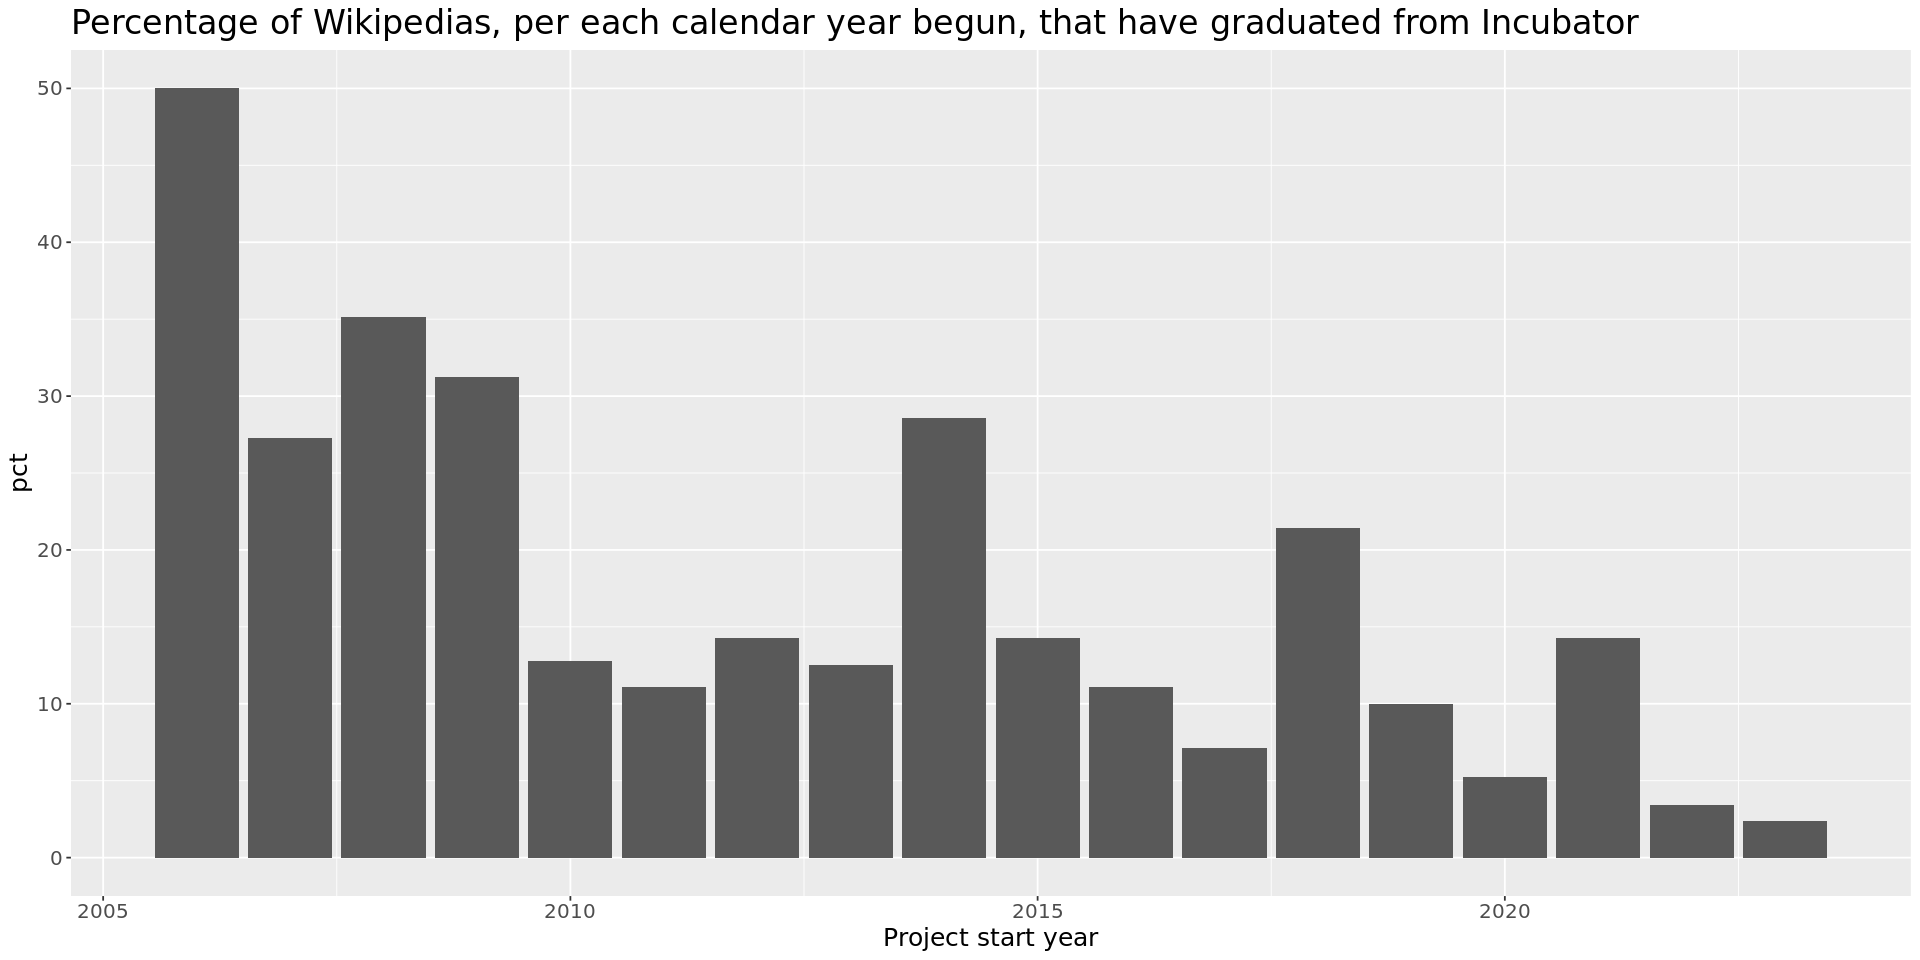

In [13]:
## PLOT 1
moe_crosstab(df=(ftgoc %>% filter(project=="Wikipedia")), 
                 x=first_edit_year, y=grad_yn, weight=weight) %>%
  filter(grad_yn == "Yes") %>%
  filter(first_edit_year > 2005) %>%
  ggplot(aes(x=first_edit_year, y=pct)) +
  geom_bar(stat="identity") +
  labs(title = "Percentage of Wikipedias, per each calendar year begun, that have graduated from Incubator") +
  xlab('Project start year') +
  theme(plot.title = element_text(size=20), axis.title = element_text(size=15), axis.text = element_text(size=12))

## NOTE THAT THE OLDER PROEJCTS WILL TEND TO HAVE HIGHER PERCENTAGES, DUE TO HAVING HAD MORE YEARS TO COMPLETE
## THUS, THIS SHOULD NOT BE INTERPRETED AS SHOWING THAT GRADUATION RATES ARE DECREASING

## Analysis of current and graduated Incubator projects' graduated-in-less-than.. rates

In [14]:
## Prep columns for conditional coding
ftgoc <- ftgoc %>%
 mutate(grad_less_1 = "No") %>%
 mutate(grad_less_2 = "No") %>%
 mutate(grad_less_3 = "No") %>%
 mutate(grad_less_4 = "No") %>%
 mutate(grad_less_5 = "No") %>%
 mutate(grad_less_6 = "No") 

## Code for: graduated in < 1, 2, 3, 4, 5, 6 years
ftgoc$grad_less_1[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<365] <- "Yes" # 365 x 1
ftgoc$grad_less_2[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<730] <- "Yes" # 365 x 2
ftgoc$grad_less_3[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<1095] <- "Yes" # 365 x 3
ftgoc$grad_less_4[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<1461] <- "Yes" # 365 x 4, + 1 for leap year day
ftgoc$grad_less_5[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<1826] <- "Yes" # 365 x 5, + 1 for leap year day
ftgoc$grad_less_6[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<2191] <- "Yes" # 365 x 6, + 1 for leap year day

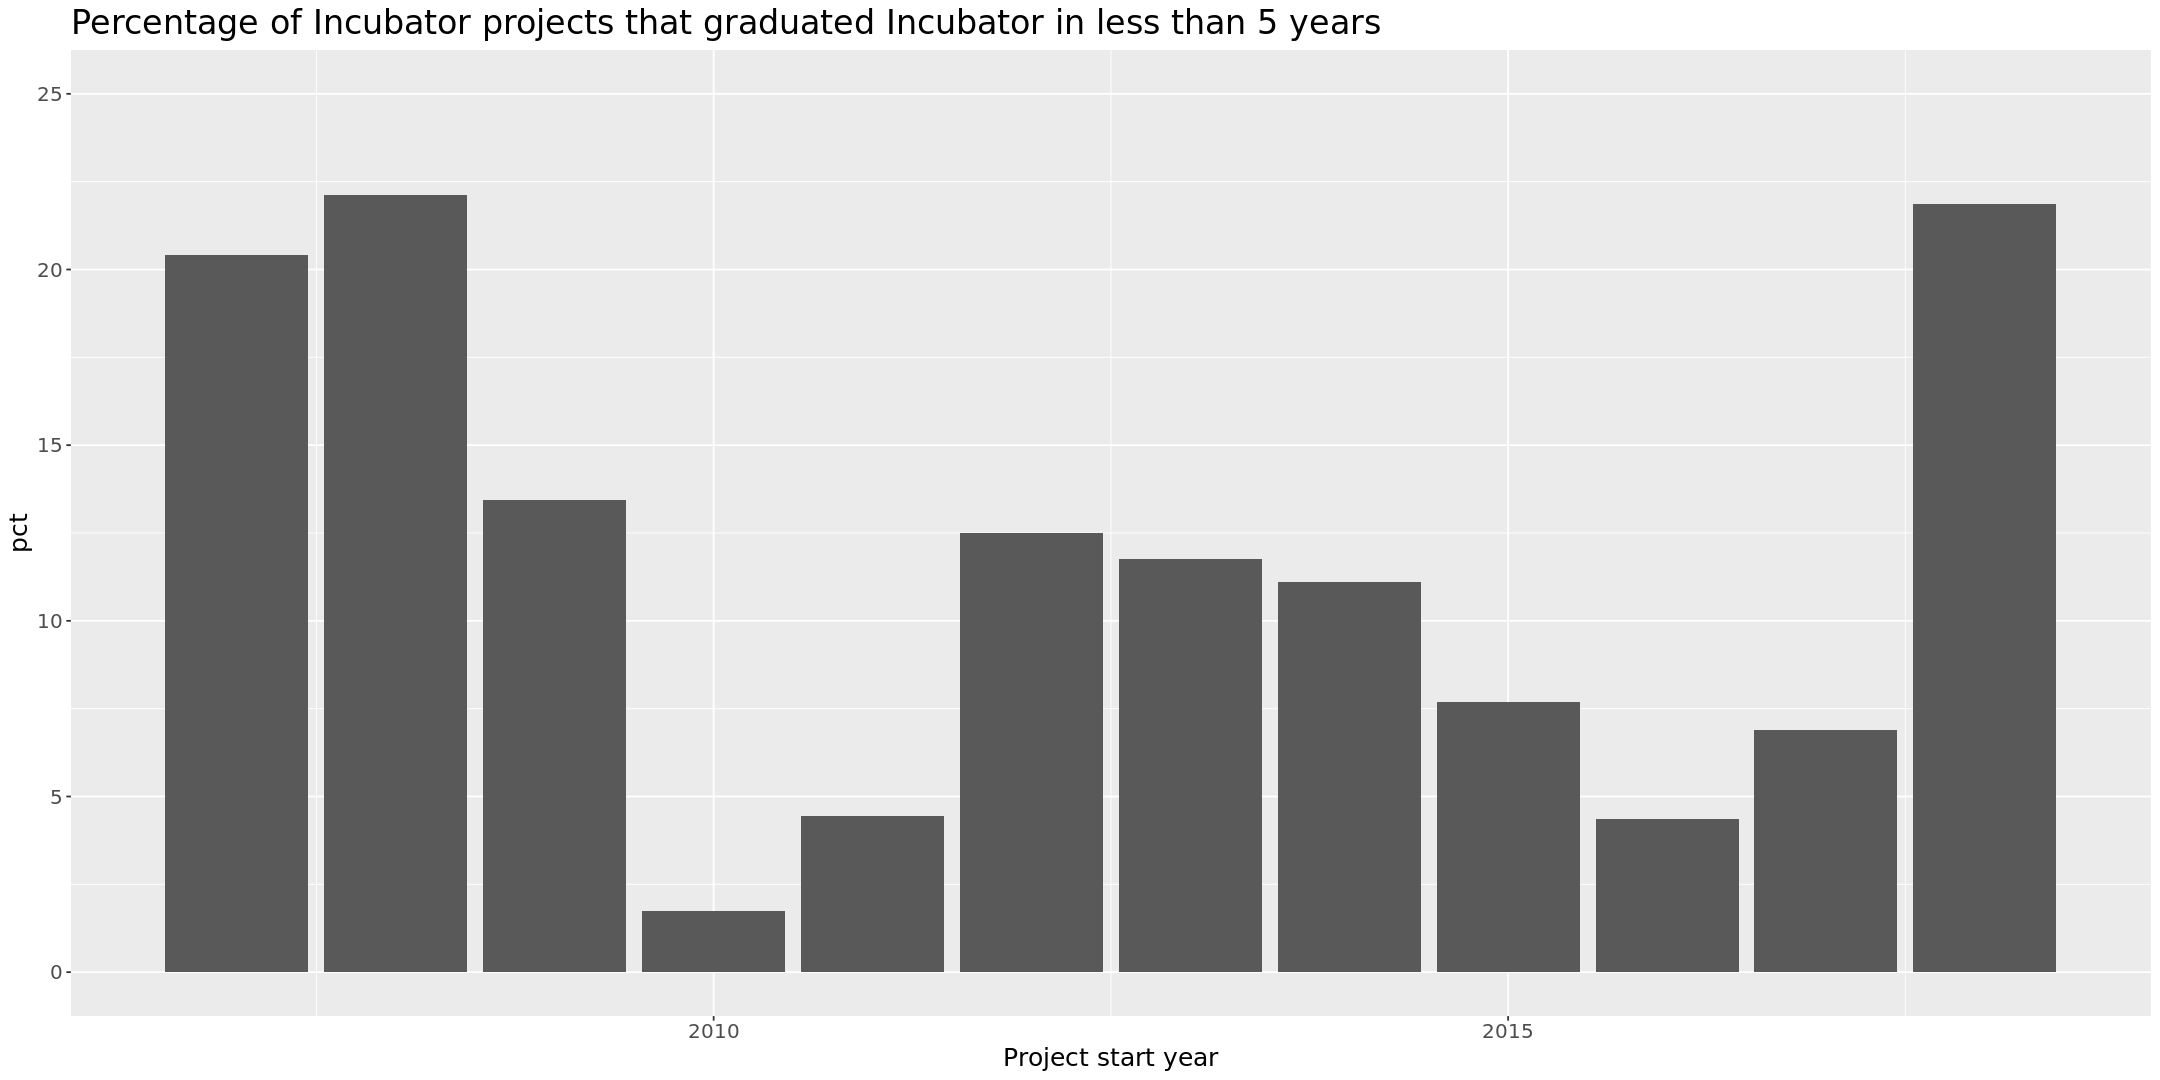

In [29]:
## PLOT 2
options(repr.plot.width=18, repr.plot.height=9)

## Plot Option A: Projects that graduted in < 5 years
moe_crosstab(df=(ftgoc), 
             x=first_edit_year, y=grad_less_5, weight=weight) %>%
  filter(grad_less_5 == "Yes") %>%
  filter(first_edit_year > 2006) %>% # exclude 2006 because very different at that time
  filter(first_edit_year < 2019) %>% # exclude 2019 and later because we haven't had a full 5 years for all those
  ggplot(aes(x=first_edit_year, y=pct)) +
  geom_bar(stat="identity") +
  labs(title = "Percentage of Incubator projects that graduated Incubator in less than 5 years") +
  xlab('Project start year') +
  theme(plot.title = element_text(size=20), axis.title = element_text(size=15), axis.text = element_text(size=12))+
  ylim(0, 25)


## Plot Option B: Projects that graduted in < 3 years
#moe_crosstab(df=(ftgoc), 
#             x=first_edit_year, y=grad_less_3, weight=weight) %>%
#  filter(grad_less_3 == "Yes") %>%
#  filter(first_edit_year > 2006) %>% # exclude 2006 because very different at that time
#  filter(first_edit_year < 2021) %>% # exclude 2021 and later because we haven't had a full 3 years for all those
#  ggplot(aes(x=first_edit_year, y=pct)) +
#  geom_bar(stat="identity") +
#  labs(title = "Percentage of Incubator projects that graduated Incubator in less than 3 years") +
#  xlab('Project start year') +
#  theme(plot.title = element_text(size=20), axis.title = element_text(size=15), axis.text = element_text(size=12))+
#  ylim(0, 25)

## Plot Option C: Projects that graduted in < 1 year
#moe_crosstab(df=(ftgoc), 
#             x=first_edit_year, y=grad_less_1, weight=weight) %>%
#  filter(grad_less_1 == "Yes") %>%
#  filter(first_edit_year > 2006) %>% # exclude 2006 because very different at that time
#  filter(first_edit_year < 2023) %>% # exclude 2023 and later because we haven't had a full 3 years for all those
#  ggplot(aes(x=first_edit_year, y=pct)) +
#  geom_bar(stat="identity") +
#  labs(title = "Percentage of Incubator projects that graduated Incubator in less than 1 year") +
#  xlab('Project start year') +
#  theme(plot.title = element_text(size=20), axis.title = element_text(size=15), axis.text = element_text(size=12))+
#  ylim(0, 25)

## Analysis of current and graduated Incubator projects' graduated-in-x-years.. rates

In [30]:
### For the following, No will be coded as 0 and Yes will be coded as 1

## Prep columns for conditional coding
ftgoc <- ftgoc %>%
 mutate(grad_in_0to1 = 0) %>%
 mutate(grad_in_1to2 = 0) %>%
 mutate(grad_in_2to3 = 0) %>%
 mutate(grad_in_3to4 = 0) %>%
 mutate(grad_in_4to5 = 0) %>%
 mutate(grad_in_3plus = 0) %>%
 mutate(grad_in_4plus = 0) %>%
 mutate(grad_in_5plus = 0) %>%
 mutate(not_yet_grad = 0) 


## Code for: graduated in 0-1 year
ftgoc$grad_in_0to1[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<365 & ftgoc$grads_total_days_in_incubator_if_grad>0] <- 1 # 365 x 1, 365 x 0
ftgoc$grad_in_0to1[ftgoc$days_since_started<365] <- NA # exclude those that could not have possibly graduated in < 1 year

## Code for: graduated in 1-2 years
ftgoc$grad_in_1to2[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<730 & ftgoc$grads_total_days_in_incubator_if_grad>=365] <- 1 # 365 x 2, 365 x 1
ftgoc$grad_in_1to2[ftgoc$days_since_started<730] <- NA # exclude those that could not have possibly graduated in < 2 years

## Code for: graduated in 2-3 years
ftgoc$grad_in_2to3[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<1095 & ftgoc$grads_total_days_in_incubator_if_grad>=730] <- 1 # 365 x 3, 365 x 2
ftgoc$grad_in_2to3[ftgoc$days_since_started<1095] <- NA # exclude those that could not have possibly graduated in < 3 years

## Code for: graduated in 3-4 years
ftgoc$grad_in_3to4[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<1461 & ftgoc$grads_total_days_in_incubator_if_grad>=1095] <- 1 # 365 x 4, + 1 for leap year day, # 365 x 3
ftgoc$grad_in_3to4[ftgoc$days_since_started<1461] <- NA # exclude those that could not have possibly graduated in < 4 years

## Code for: graduated in 4-5 years
ftgoc$grad_in_4to5[ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad<1826 & ftgoc$grads_total_days_in_incubator_if_grad>=1461] <- 1 # 365 x 5, + 1 for leap year day, 365 x 4, + 1 for leap year day
ftgoc$grad_in_4to5[ftgoc$days_since_started<1826] <- NA # exclude those that could not have possibly graduated in < 5 years

## Code for: graduated in 3+ years
ftgoc$grad_in_3plus[(ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad>=1095)] <- 1 # 365 x 3

## Code for: graduated in 4+ years
ftgoc$grad_in_4plus[(ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad>=1461)] <- 1 # 365 x 4, + 1 for leap year day, 

## Code for: graduated in 5+ years
ftgoc$grad_in_5plus[(ftgoc$grad_yn=="Yes" & ftgoc$grads_total_days_in_incubator_if_grad>=1826)] <- 1 # 365 x 5, + 1 for leap year day

## Code for: not yet graduated
ftgoc$not_yet_grad[(ftgoc$grad_yn=="No")] <- 1 


In [31]:
##checks
head(ftgoc %>% 
     select(first_edit_year, grad_yn, days_since_started, grads_total_days_in_incubator_if_grad, grad_in_0to1, grad_in_1to2, grad_in_2to3, grad_in_3to4, grad_in_4to5, grad_in_5plus))
#head(ftgoc %>% filter(grad_yn=="Yes") %>% 
#     select(first_edit_year, grad_yn, grads_total_days_in_incubator_if_grad, grad_in_0to1, grad_in_1to2, grad_in_2to3, grad_in_3to4, grad_in_4to5, grad_in_5plus))
#tail(ftgoc %>% 
#     select(first_edit_year, grad_yn, grads_total_days_in_incubator_if_grad, grad_in_0to1, grad_in_1to2, grad_in_2to3, grad_in_3to4, grad_in_4to5, grad_in_5plus))

first_edit_year grad_yn days_since_started
1 2023            No       263 days         
2 2023            No       402 days         
3 2019            No      1705 days         
4 2023            No       110 days         
5 2023            No       235 days         
6 2024            No        76 days         
  grads_total_days_in_incubator_if_grad grad_in_0to1 grad_in_1to2 grad_in_2to3
1 NA                                    NA           NA           NA          
2 NA                                     0           NA           NA          
3 NA                                     0            0            0          
4 NA                                    NA           NA           NA          
5 NA                                    NA           NA           NA          
6 NA                                    NA           NA           NA          
  grad_in_3to4 grad_in_4to5 grad_in_5plus
1 NA           NA           0            
2 NA           NA           0            
3  0           NA           0            
4 NA           NA           0            
5 NA           NA           0            
6 NA           NA           0

In [32]:
## Make data long
ftgoc_long <- ftgoc %>%
  select(-c(grad_less_1:grad_less_6, date_type, date, current_dt, weight)) %>%
  gather(., key="grad_in_bucket", value="count", 
        c(grad_in_0to1, grad_in_1to2, grad_in_2to3,
          grad_in_3to4, grad_in_4to5, grad_in_3plus,
          grad_in_4plus, grad_in_5plus, not_yet_grad)) %>%
  distinct(.) %>%
  mutate(weight=1) # add dummy weight

##checks--
#head(ftgoc_long %>% arrange(prefix))
#tail(ftgoc_long)
#xtabs(~`grad_in_bucket`+first_edit_year, ftgoc_long)
#head(moe_crosstab_3way(df=ftgoc_long%>%filter(first_edit_year>2006), 
#                       x=`grad_in_bucket`, y=count, z=first_edit_year, weight=weight))

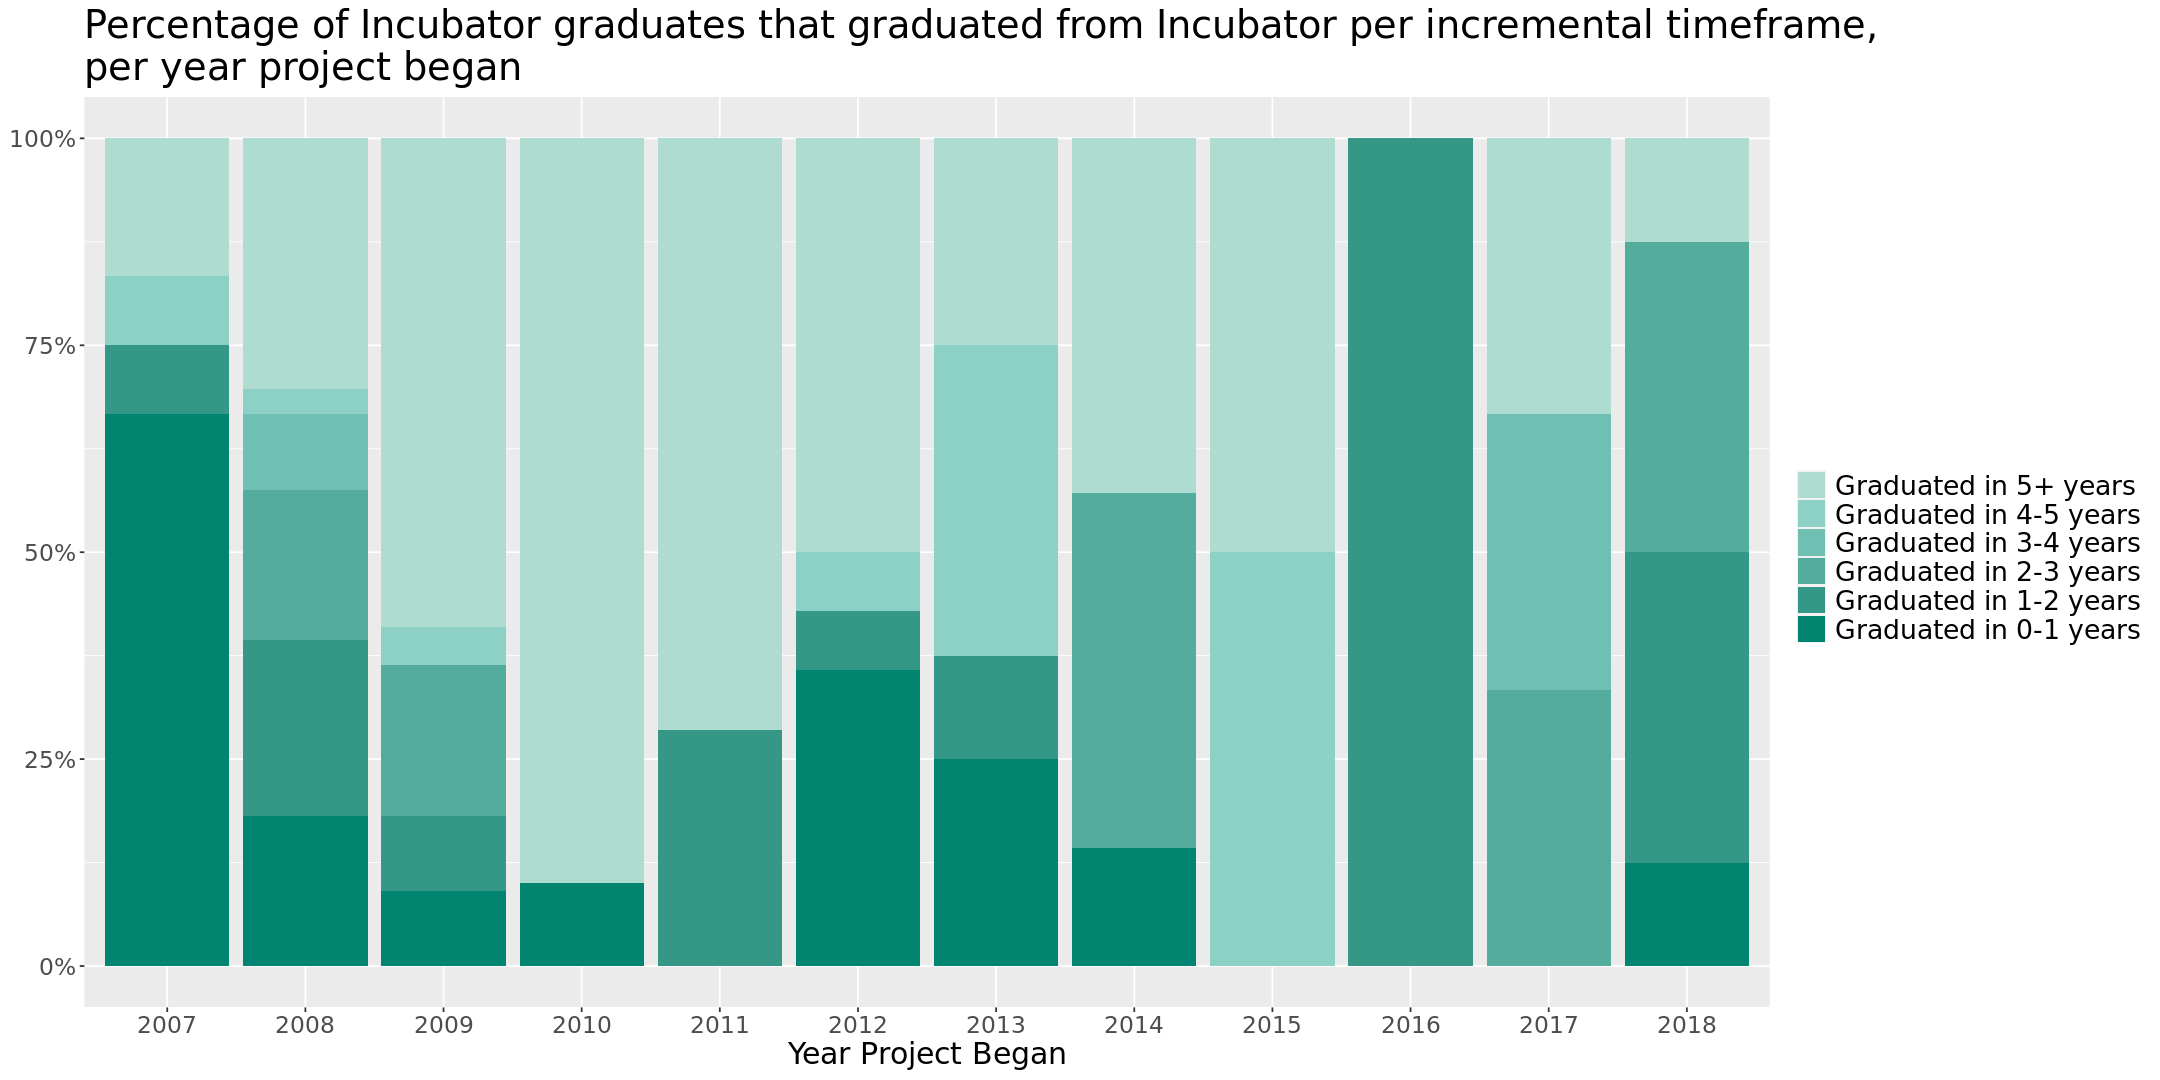

In [33]:
## PLOT 4 
## PLOT ALL PROJECTS, DISTRIBUTION (%) OF YEARS OF TIME TAKEN TO GRADUATE INCUBATOR, PER YEAR BEGUN

# make factors for ordering
ftgoc_long$grad_in_bucket <- factor(ftgoc_long$grad_in_bucket,
                                   levels = c("not_yet_grad", "grad_in_5plus", "grad_in_4plus","grad_in_3plus",
                                              "grad_in_4to5", "grad_in_3to4", "grad_in_2to3", "grad_in_1to2",
                                              "grad_in_0to1"))

# plot
ftgoc_long %>%
  filter(first_edit_year > 2006 & first_edit_year < 2019) %>%
  filter(grad_in_bucket!="grad_in_3plus" & 
         grad_in_bucket!="grad_in_4plus" &   
     #    grad_in_bucket!="grad_in_4to5" &
     #    grad_in_bucket!="grad_in_5plus" &
         grad_in_bucket!="not_yet_grad" &
         grad_in_bucket!="") %>%  
  ggplot(aes(x=first_edit_year, y=count, fill=grad_in_bucket)) +
  geom_bar(stat="identity", position="fill") +
  scale_fill_manual(labels = c("Graduated in 5+ years",
                              "Graduated in 4-5 years",
                              "Graduated in 3-4 years",
                              "Graduated in 2-3 years",
                              "Graduated in 1-2 years",
                              "Graduated in 0-1 years"),
                    values = c("#AFDcd1", 
                               "#8dd1c6",
                               "#6fc0b3",
                               "#53Ac9C",
                               "#359886",
                               "#018571"
                               )) +
  theme(plot.title=element_text(size=23), plot.subtitle=element_text(size=18), axis.title.x=element_text(size=18), axis.title.y=element_blank(), 
        legend.position="right", axis.text=element_text(size=14),
        legend.title=element_blank(), legend.text=element_text(size=16)) +
 labs(title = "Percentage of Incubator graduates that graduated from Incubator per incremental timeframe, \nper year project began") +
  xlab("Year Project Began") + ylab("Percentage") +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"))

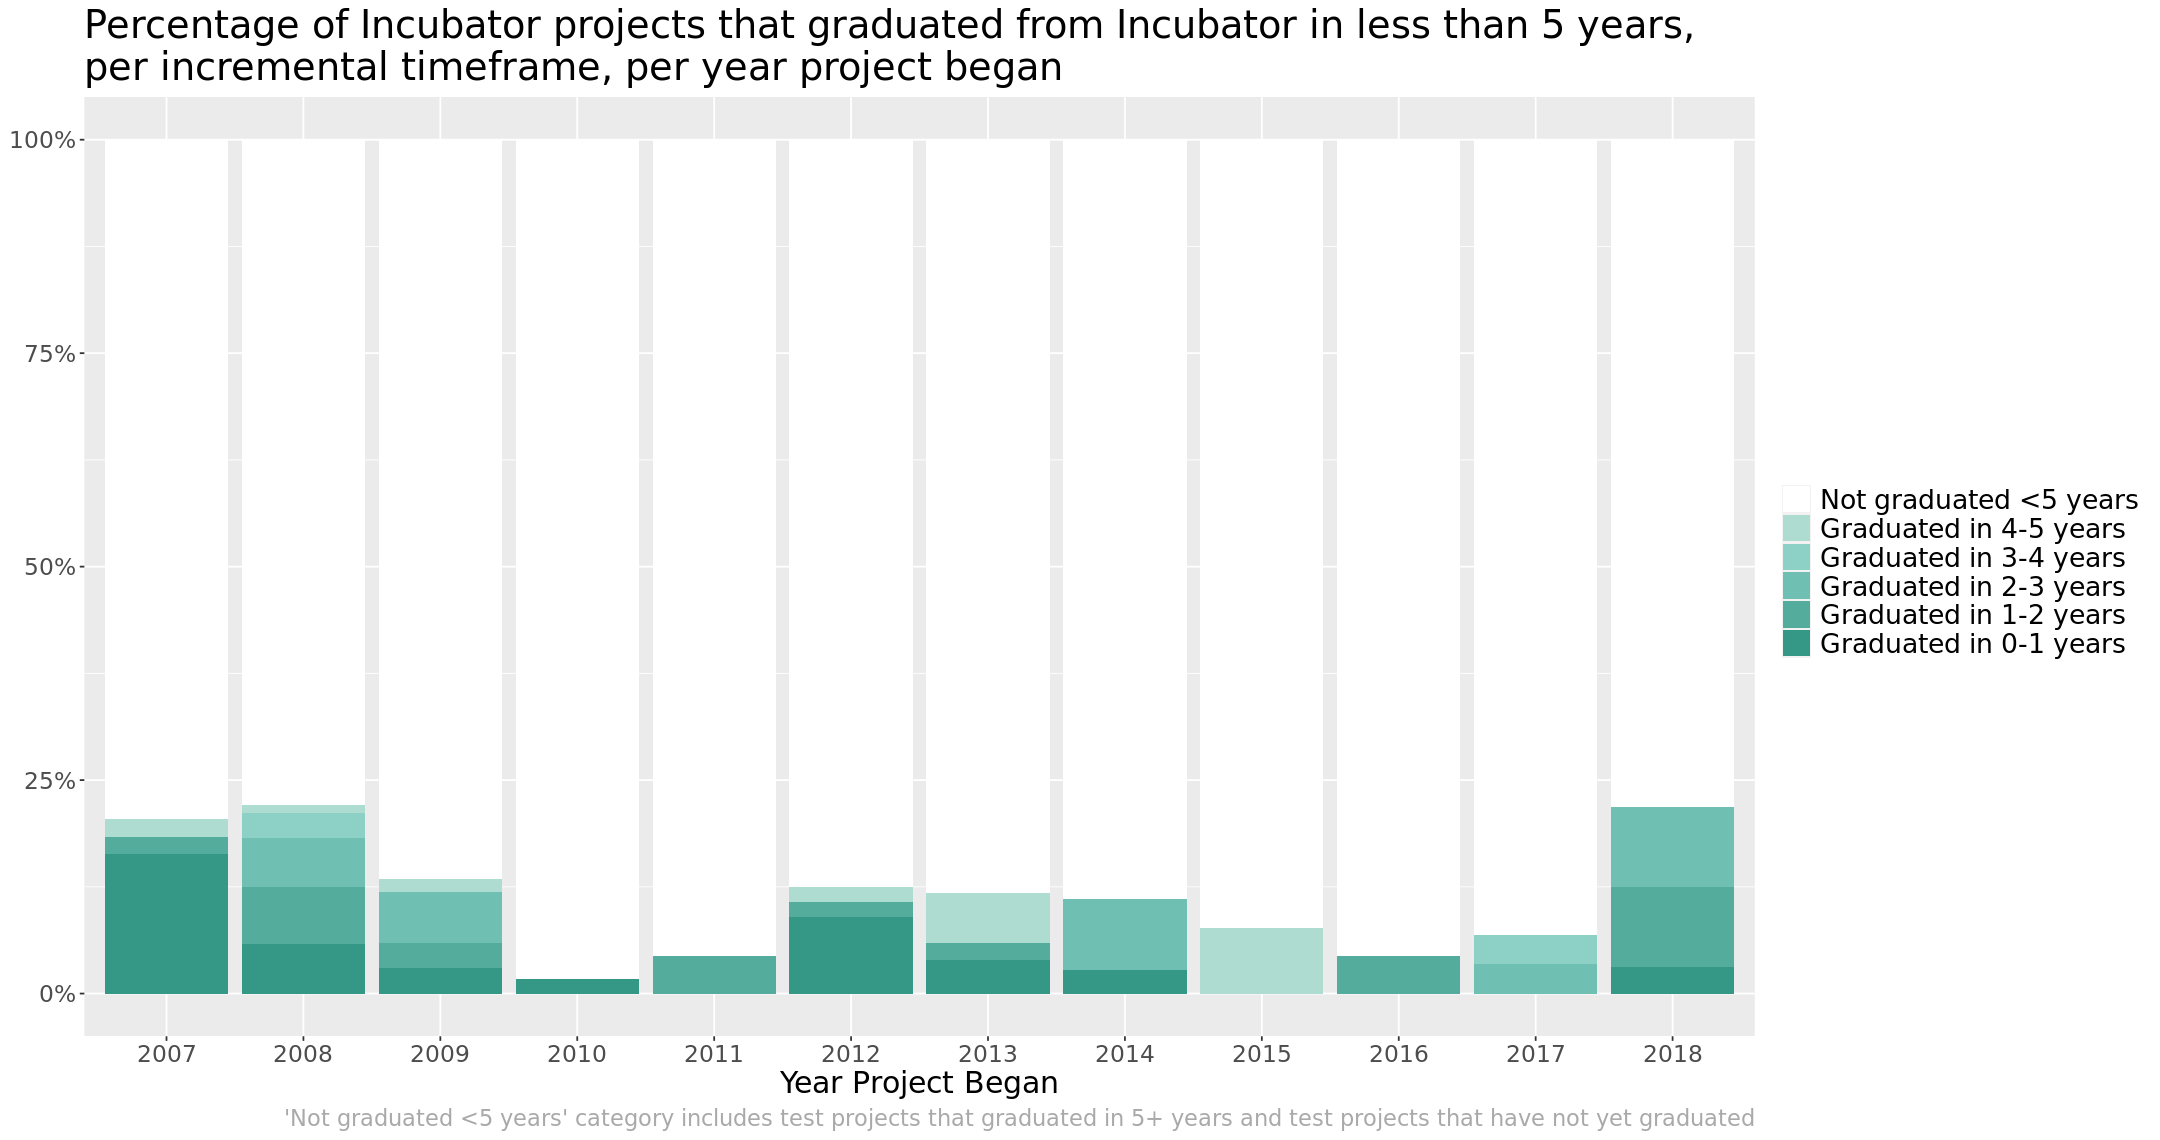

In [34]:
## PLOT 4.b 
options(repr.plot.width=18, repr.plot.height=9.5)

## PLOT ALL PROJECTS, DISTRIBUTION (%) OF YEARS OF TIME TAKEN TO GRADUATE INCUBATOR, PER YEAR BEGUN
## --> INCLUDE THOSE WHO HAVEN'T GRADUATED YET <--
## Shows the same info as Plot 2, but also breaks down year ranges of time-to-graduation under 5 years

# prep
ftgoc_long_ab <- ftgoc_long
ftgoc_long_ab$grad_in_bucket <- as.character(ftgoc_long_ab$grad_in_bucket)

ftgoc_long_ab$grad_in_bucket[ftgoc_long_ab$grad_in_bucket=="grad_in_5plus" |
                            ftgoc_long_ab$grad_in_bucket=="not_yet_grad"] <- "not_grad_<5"

ftgoc_long_ab$grad_in_bucket <- factor(ftgoc_long_ab$grad_in_bucket,
                                   levels = c("not_grad_<5", "grad_in_4plus", "grad_in_3plus", "grad_in_4to5",
                                             "grad_in_3to4", "grad_in_2to3", "grad_in_1to2", "grad_in_0to1"))
# plot
ftgoc_long_ab %>%
  filter(first_edit_year > 2006 & first_edit_year < 2019) %>%
  filter(grad_in_bucket!="grad_in_3plus" & 
         grad_in_bucket!="grad_in_4plus" &   
     #    grad_in_bucket!="grad_in_4to5" &
     #    grad_in_bucket!="grad_in_5plus" &
     #    grad_in_bucket!="not_yet_grad" &
         grad_in_bucket!="") %>%  
  ggplot(aes(x=first_edit_year, y=count, fill=grad_in_bucket)) +
  geom_bar(stat="identity", position="fill") +
 scale_fill_manual(labels = c("Not graduated <5 years",
                              "Graduated in 4-5 years",
                              "Graduated in 3-4 years",
                              "Graduated in 2-3 years",
                              "Graduated in 1-2 years",
                              "Graduated in 0-1 years"),
                    values = c("white",
                               "#AFDcd1", 
                               "#8dd1c6",
                               "#6fc0b3",
                               "#53Ac9C",
                               "#359886",
                               "#018571")) +
  theme(plot.title=element_text(size=23), plot.subtitle=element_text(size=18), axis.title.x=element_text(size=18), axis.title.y=element_blank(), 
        legend.position="right", axis.text=element_text(size=14), plot.caption=element_text(size=13.5, color="dark grey"),
        legend.title=element_blank(), legend.text=element_text(size=16)) +
 labs(title = "Percentage of Incubator projects that graduated from Incubator in less than 5 years, \nper incremental timeframe, per year project began",
       caption = "'Not graduated <5 years' category includes test projects that graduated in 5+ years and test projects that have not yet graduated") +
  xlab("Year Project Began") + ylab("Percentage") +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"))

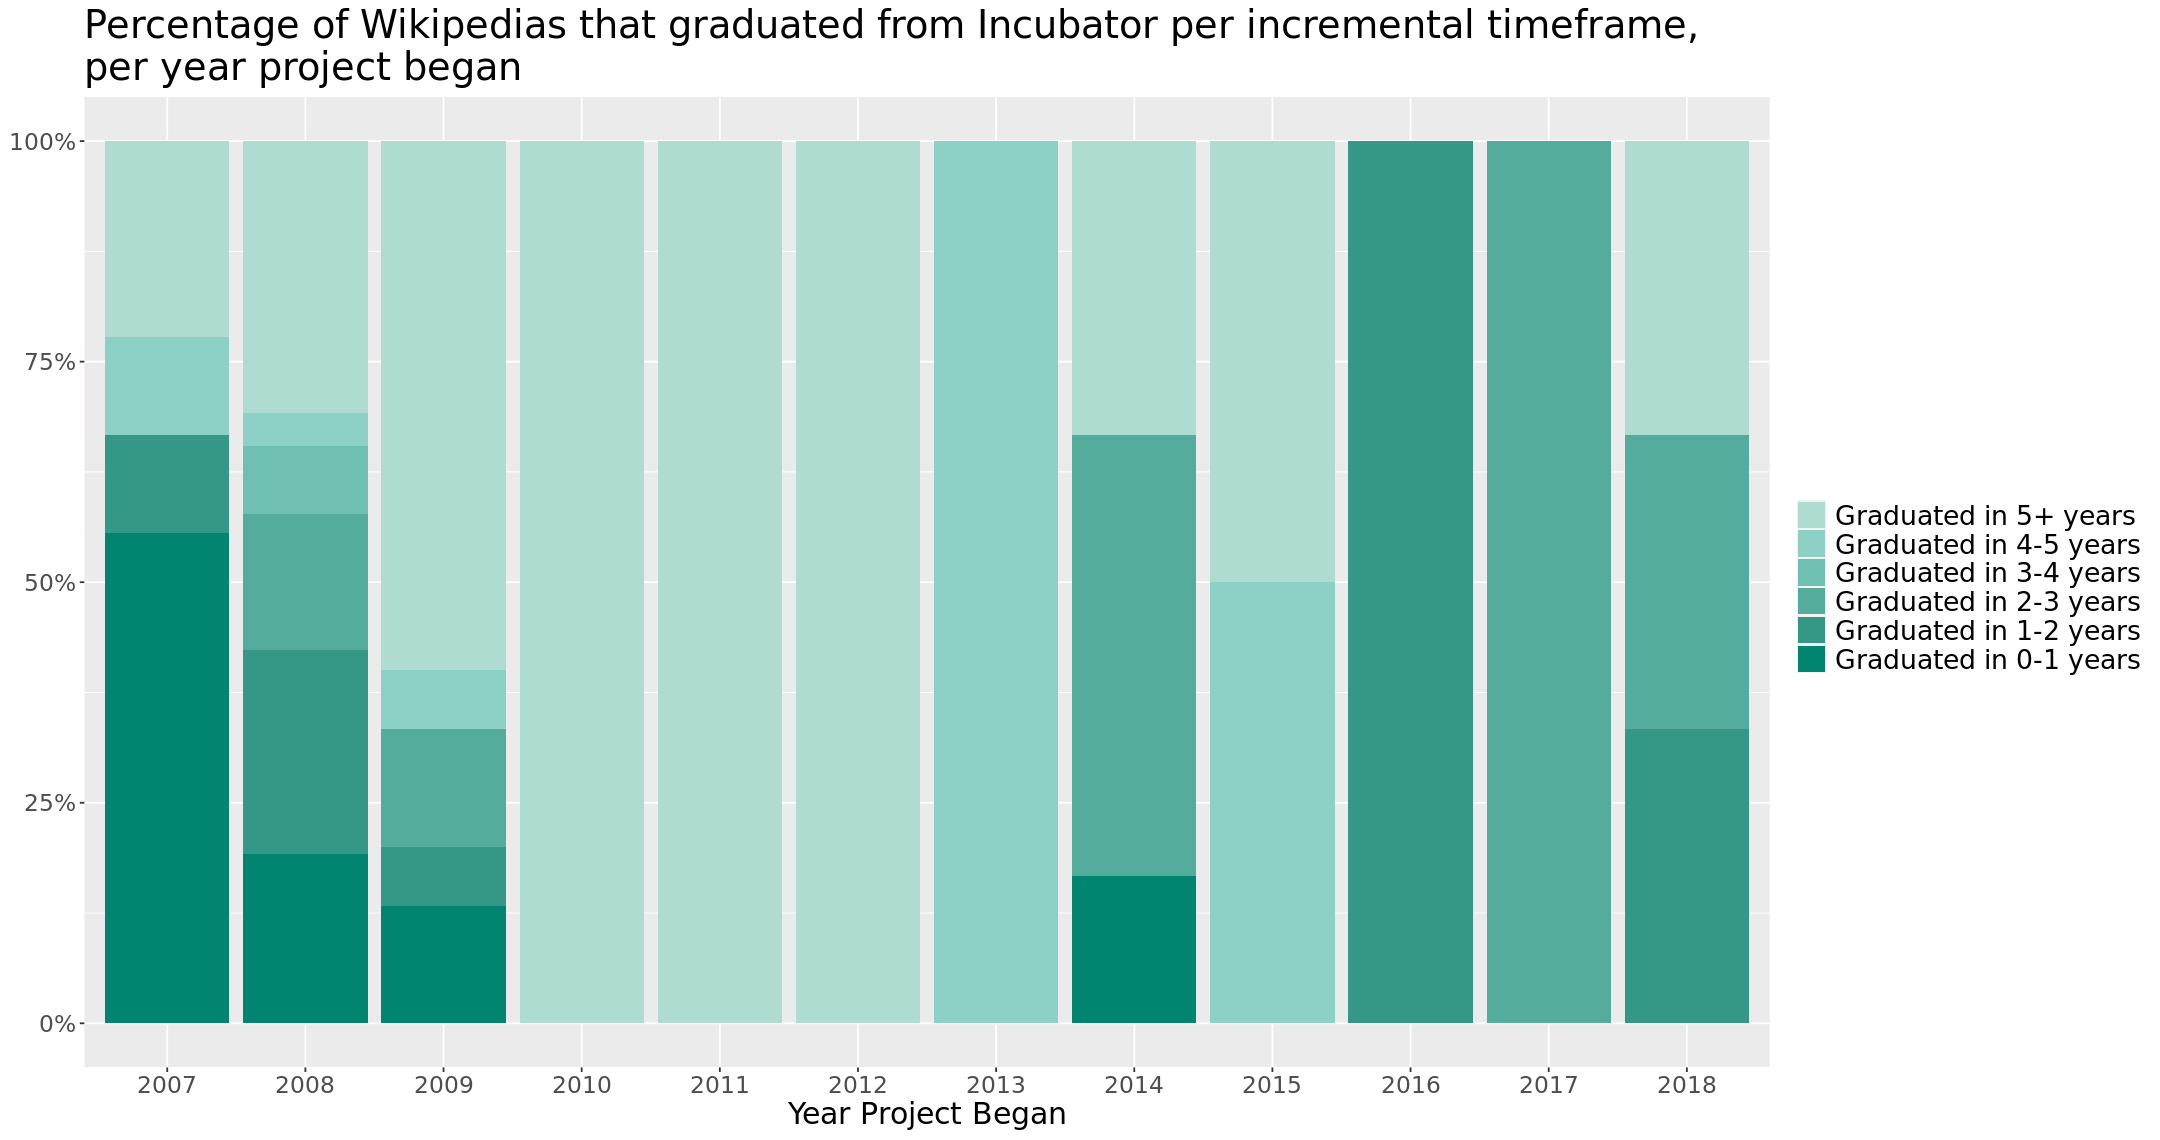

In [35]:
## PLOT 5
## PLOT WIKIPEDIAS ONLY, DISTRIBUTION (%) OF YEARS OF TIME TAKEN TO GRADUATE INCUBATOR, PER YEAR BEGUN
## (Same as plot 4 but wikipedias only)

# make factors for ordering
ftgoc_long$grad_in_bucket <- factor(ftgoc_long$grad_in_bucket,
                                   levels = c("not_yet_grad", "grad_in_5plus", "grad_in_4plus", "grad_in_3plus",
                                             "grad_in_4to5", "grad_in_3to4", "grad_in_2to3", "grad_in_1to2", 
                                             "grad_in_0to1"))

# plot
ftgoc_long %>%
  filter(first_edit_year > 2006 & first_edit_year < 2019) %>%
  filter(project=="Wikipedia") %>% # <------- here's where Wikipedia is filtered for
  filter(grad_in_bucket!="grad_in_3plus" & 
         grad_in_bucket!="grad_in_4plus" &   
     #    grad_in_bucket!="grad_in_4to5" &
     #    grad_in_bucket!="grad_in_5plus" &
         grad_in_bucket!="not_yet_grad" &
         grad_in_bucket!="") %>%  
  ggplot(aes(x=first_edit_year, y=count, fill=grad_in_bucket)) +
  geom_bar(stat="identity", position="fill") +
  scale_fill_manual(labels = c("Graduated in 5+ years",
                              "Graduated in 4-5 years",
                              "Graduated in 3-4 years",
                              "Graduated in 2-3 years",
                              "Graduated in 1-2 years",
                              "Graduated in 0-1 years"),
                    values = c("#AFDcd1", 
                               "#8dd1c6",
                               "#6fc0b3",
                               "#53Ac9C",
                               "#359886",
                               "#018571"
                               )) +
  theme(plot.title=element_text(size=23), plot.subtitle=element_text(size=18), axis.title.x=element_text(size=18), axis.title.y=element_blank(), 
        legend.position="right", axis.text=element_text(size=14),
        legend.title=element_blank(), legend.text=element_text(size=16)) +
 labs(title = "Percentage of Wikipedias that graduated from Incubator per incremental timeframe, \nper year project began") +
  xlab("Year Project Began") + ylab("Percentage") +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"))

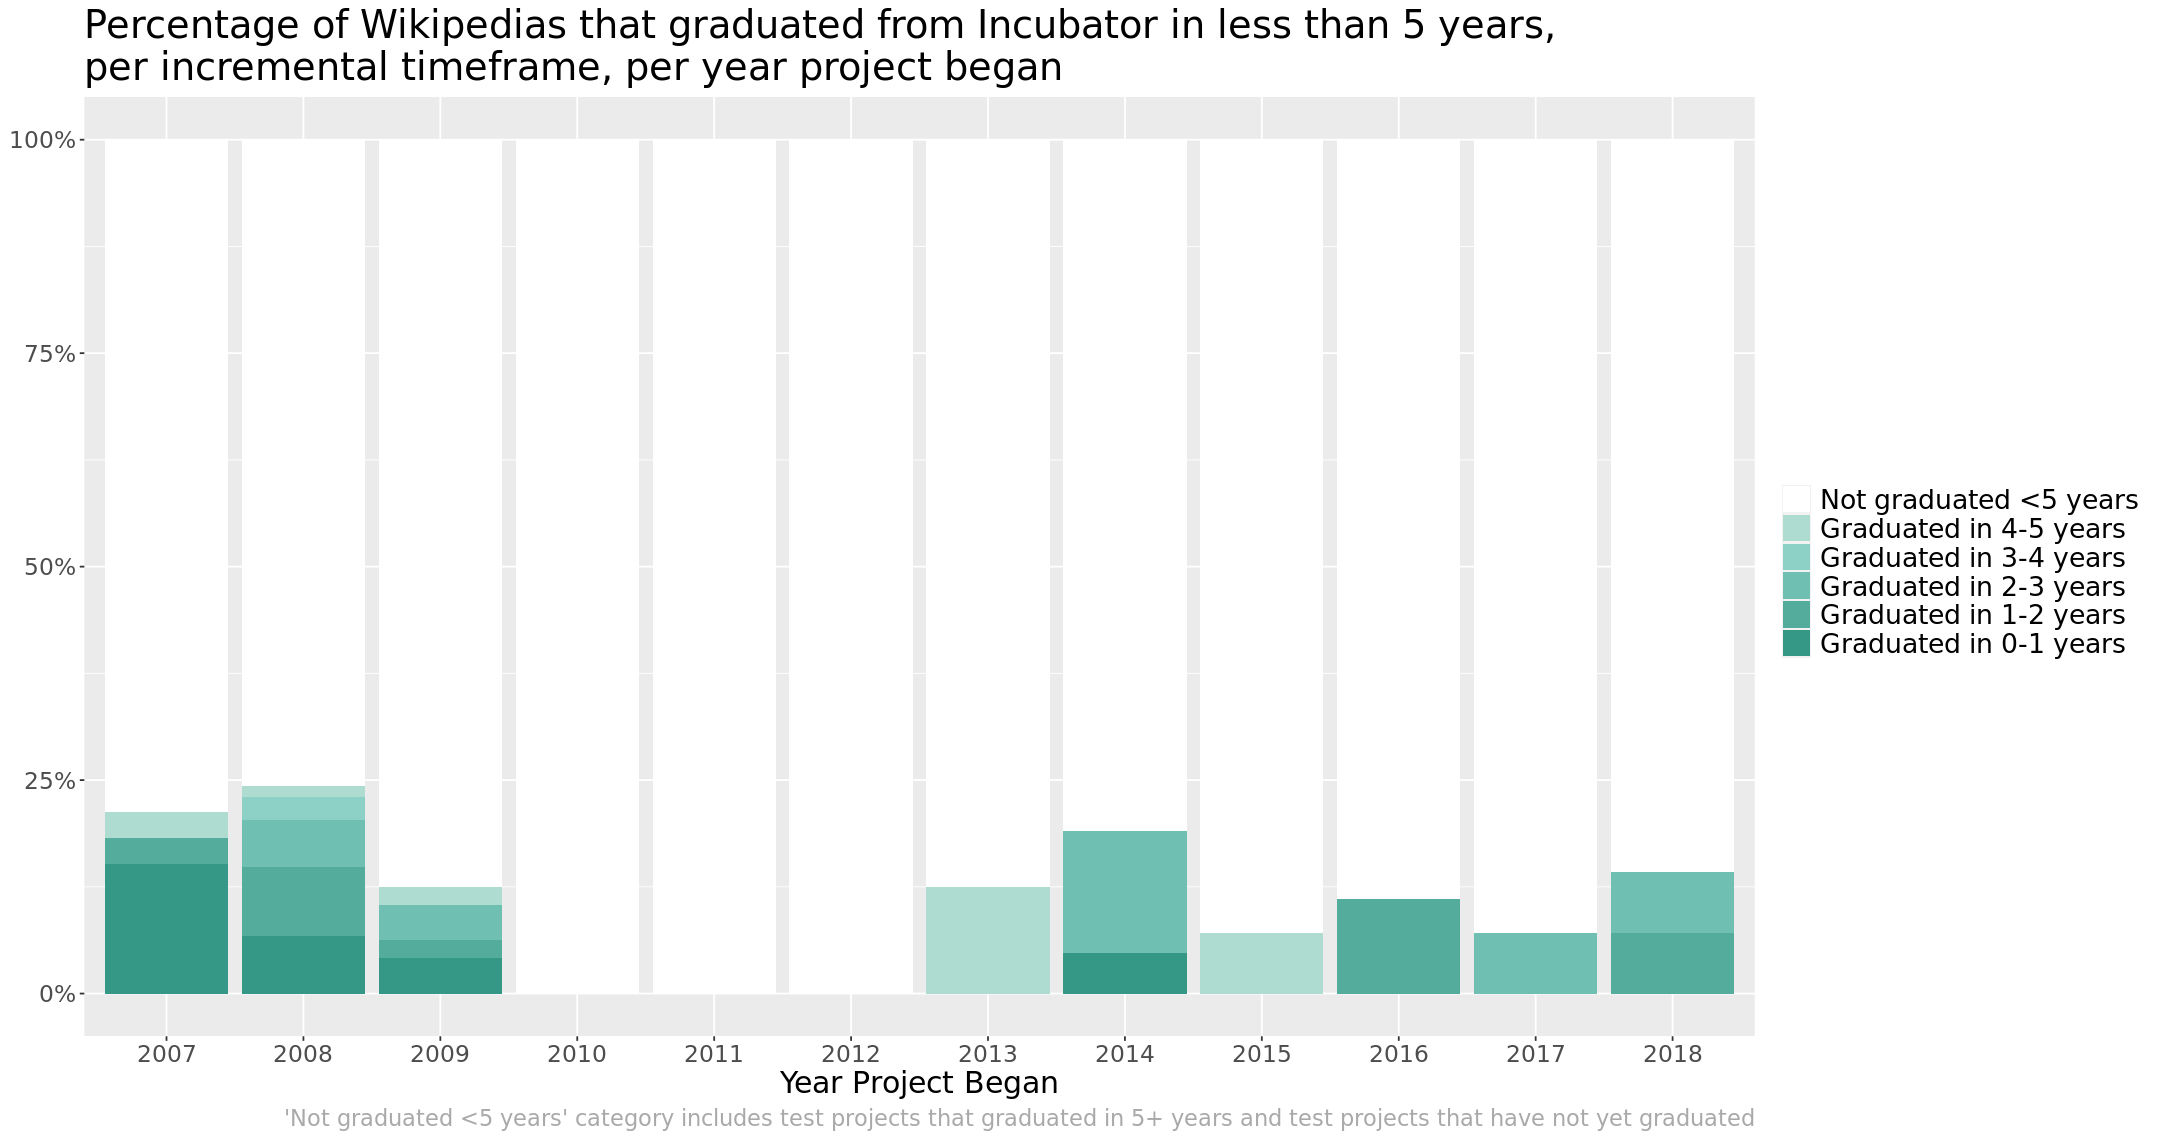

In [36]:
## PLOT 5.b

## PLOT WIKIPEDIAS ONLY, DISTRIBUTION (%) OF YEARS OF TIME TAKEN TO GRADUATE INCUBATOR, PER YEAR BEGUN
## (Same as plot 4.b but wikipedias only)

# prep
ftgoc_long_ab <- ftgoc_long
ftgoc_long_ab$grad_in_bucket <- as.character(ftgoc_long_ab$grad_in_bucket)

ftgoc_long_ab$grad_in_bucket[ftgoc_long_ab$grad_in_bucket=="grad_in_5plus" |
                            ftgoc_long_ab$grad_in_bucket=="not_yet_grad"] <- "not_grad_<5"

ftgoc_long_ab$grad_in_bucket <- factor(ftgoc_long_ab$grad_in_bucket,
                                   levels = c("not_grad_<5", "grad_in_4plus", "grad_in_3plus", "grad_in_4to5",
                                             "grad_in_3to4", "grad_in_2to3", "grad_in_1to2", "grad_in_0to1"))
# plot
ftgoc_long_ab %>%
  filter(first_edit_year > 2006 & first_edit_year < 2019) %>%
  filter(project=="Wikipedia") %>% # <----- here's where Wikipedia is filtered for
  filter(grad_in_bucket!="grad_in_3plus" & 
         grad_in_bucket!="grad_in_4plus" &   
     #    grad_in_bucket!="grad_in_4to5" &
     #    grad_in_bucket!="grad_in_5plus" &
     #    grad_in_bucket!="not_yet_grad" &
         grad_in_bucket!="") %>%  
  ggplot(aes(x=first_edit_year, y=count, fill=grad_in_bucket)) +
  geom_bar(stat="identity", position="fill") +
 scale_fill_manual(labels = c("Not graduated <5 years",
                              "Graduated in 4-5 years",
                              "Graduated in 3-4 years",
                              "Graduated in 2-3 years",
                              "Graduated in 1-2 years",
                              "Graduated in 0-1 years"),
                    values = c("white",
                               "#AFDcd1", 
                               "#8dd1c6",
                               "#6fc0b3",
                               "#53Ac9C",
                               "#359886",
                               "#018571")) +
  theme(plot.title=element_text(size=23), plot.subtitle=element_text(size=18), axis.title.x=element_text(size=18), axis.title.y=element_blank(), 
        legend.position="right", axis.text=element_text(size=14), plot.caption=element_text(size=13.5, color="dark grey"),
        legend.title=element_blank(), legend.text=element_text(size=16)) +
 labs(title = "Percentage of Wikipedias that graduated from Incubator in less than 5 years, \nper incremental timeframe, per year project began",
       caption = "'Not graduated <5 years' category includes test projects that graduated in 5+ years and test projects that have not yet graduated") +
  xlab("Year Project Began") + ylab("Percentage") +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"))

## Analysis of graduation rates based on whether it's the language's 1st project, 2nd project, 3rd project, etc.

In [37]:
## Sequence languages by the # project of that language
ftgoc_ranked <- ftgoc %>%
  select(-c(date, date_type)) %>%
  unique() %>% 
  dplyr::arrange(first_edit_dt) %>%
  dplyr::group_by(language_name) %>% # group by language
  dplyr::mutate(id = row_number()) # give seq number (1=1st project for that language, 2=2nd project for that language, etc)

# for example of what the code above actually did, see:
head(ftgoc_ranked %>% filter(language_name=="Achinese") %>% select(1:4,17, grad_yn))

prefix language_name project    first_edit_dt grad_in_0to1 grad_yn
1 Wp/ace Achinese      Wikipedia  2008-08-26     1           Yes    
2 Wt/ace Achinese      Wiktionary 2013-01-19     0           No     
3 Wy/ace Achinese      Wikivoyage 2021-04-23     0           No     
4 Wn/ace Achinese      Wikinews   2023-07-13    NA           No     
5 Wb/ace Achinese      Wikibooks  2023-07-30    NA           No     
6 Wq/ace Achinese      Wikiquote  2023-08-19    NA           No

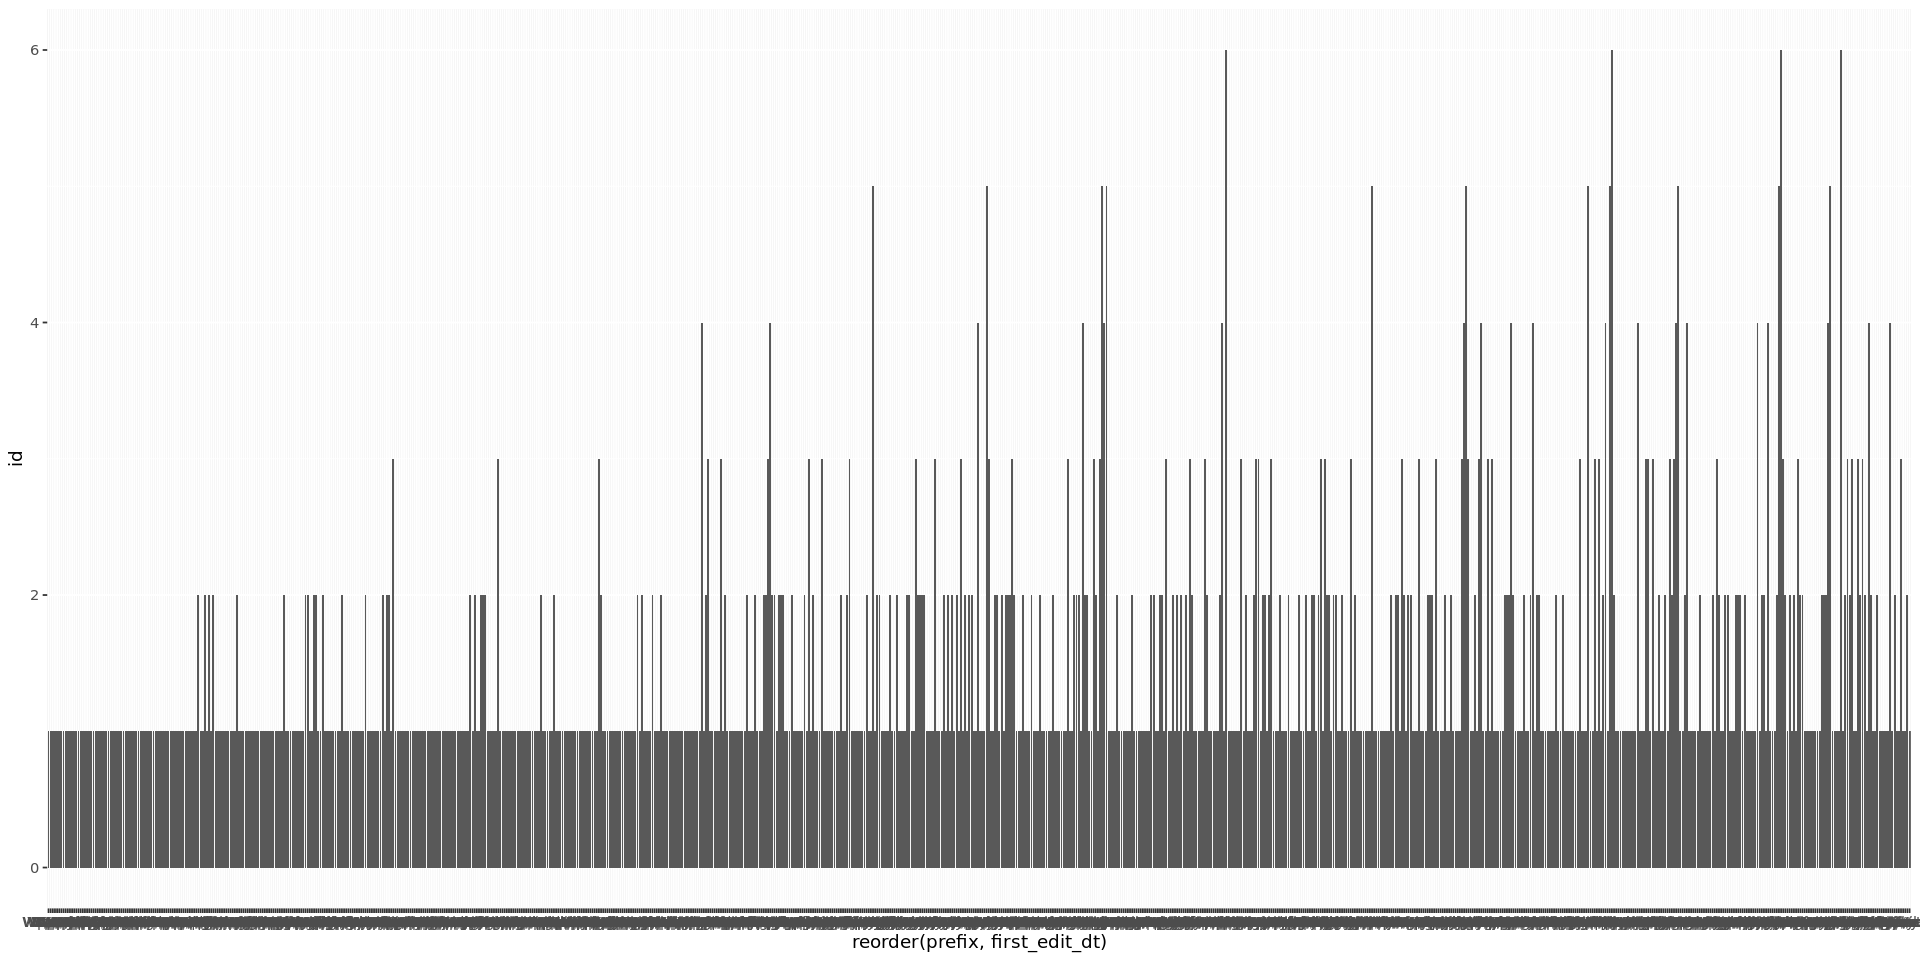

In [38]:
## PLOT 6
## Plot overview of Wikipedia project, illustrative of spacing of rankings
options(repr.plot.width=16, repr.plot.height=8)
ftgoc_ranked %>% 
  ggplot(aes(x=reorder(prefix, first_edit_dt), y=id)) +
  geom_bar(stat="identity")

In [39]:
## Sequence languages by the # project of that language, and if prev graduated
ftgoc_ranked$prev_proj_grad <- NA
ftgoc_ranked <- ftgoc_ranked %>%
  dplyr::group_by(language_name) %>%
  dplyr::arrange(id) %>%
  dplyr::mutate(prev_proj_grad = lag(grad_yn)) %>%
  dplyr::ungroup()

# for example of what the code above actually did, see:
ftgoc_ranked %>% 
      filter(language_name=="Achinese" | language_name=="Igbo" | language_name=="Dagbani") %>% 
      select(1:4,17, id, grad_yn, prev_proj_grad) %>%
      dplyr::arrange(language_name, id)

prefix language_name project    first_edit_dt grad_in_0to1 id grad_yn
1 Wp/ace Achinese      Wikipedia  2008-08-26     1           1  Yes    
2 Wt/ace Achinese      Wiktionary 2013-01-19     0           2  No     
3 Wy/ace Achinese      Wikivoyage 2021-04-23     0           3  No     
4 Wn/ace Achinese      Wikinews   2023-07-13    NA           4  No     
5 Wb/ace Achinese      Wikibooks  2023-07-30    NA           5  No     
6 Wq/ace Achinese      Wikiquote  2023-08-19    NA           6  No     
7 Wp/dag Dagbani       Wikipedia  2014-08-28     0           1  Yes    
8 Wq/ig  Igbo          Wikiquote  2011-07-04     0           1  Yes    
9 Wt/ig  Igbo          Wiktionary 2017-04-21     0           2  Yes    
  prev_proj_grad
1 NA            
2 Yes           
3 No            
4 No            
5 No            
6 No            
7 NA            
8 NA            
9 Yes

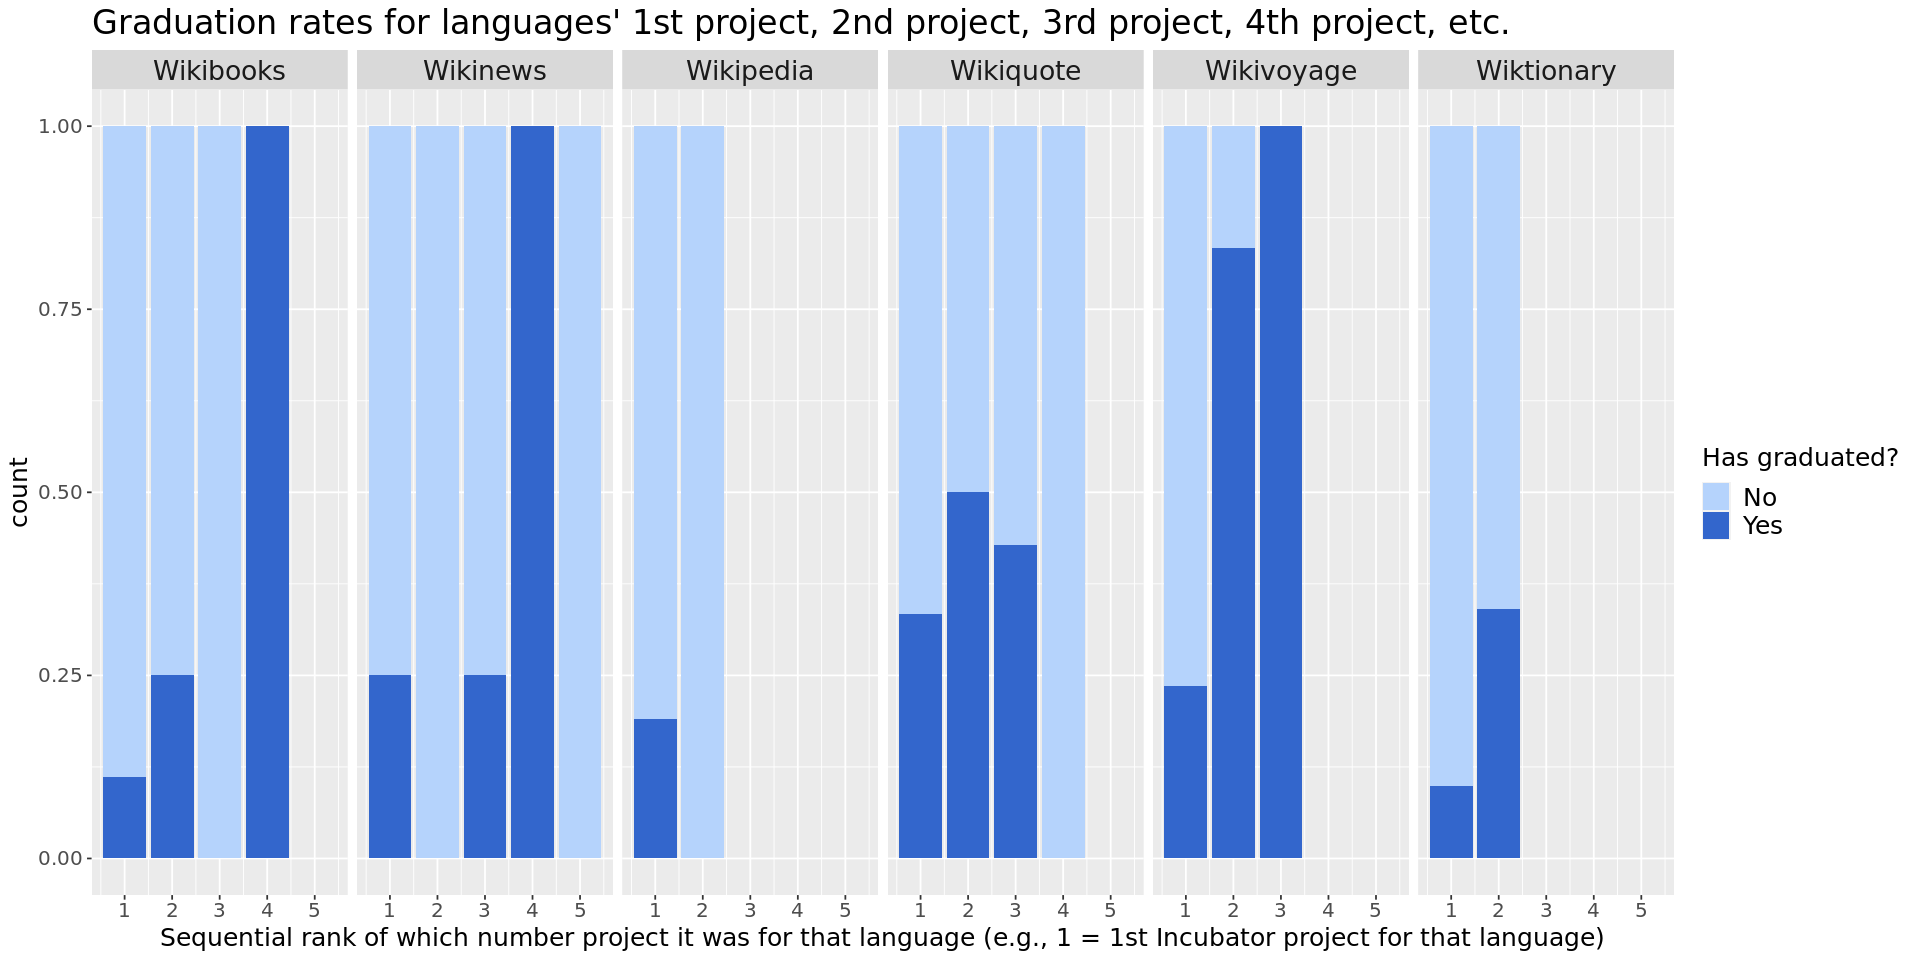

In [40]:
## PLOT 7A
## PLOT: Graduation rates for languages' 1st projects, 2nd projects if prev graduated, 3rd projects if prev graduated, etc.
ftgoc_ranked %>% 
  filter(prev_proj_grad=="Yes" | is.na(prev_proj_grad)) %>%
  ggplot(aes(x=id, fill=grad_yn)) +
  geom_bar(position="fill") +
  facet_grid(.~project) +
  labs(title = "Graduation rates for languages' 1st project, 2nd project, 3rd project, 4th project, etc.") +
  guides(fill=guide_legend(title="Has graduated?")) +
  xlab('Sequential rank of which number project it was for that language (e.g., 1 = 1st Incubator project for that language)') +
  theme(plot.title = element_text(size=20), axis.title = element_text(size=15), axis.text = element_text(size=12), 
        legend.title=element_text(size=15), legend.text=element_text(size=15), strip.text=element_text(size=16)) +
  scale_fill_manual(values = c( "#B5D3FC", "#3366cc")) 

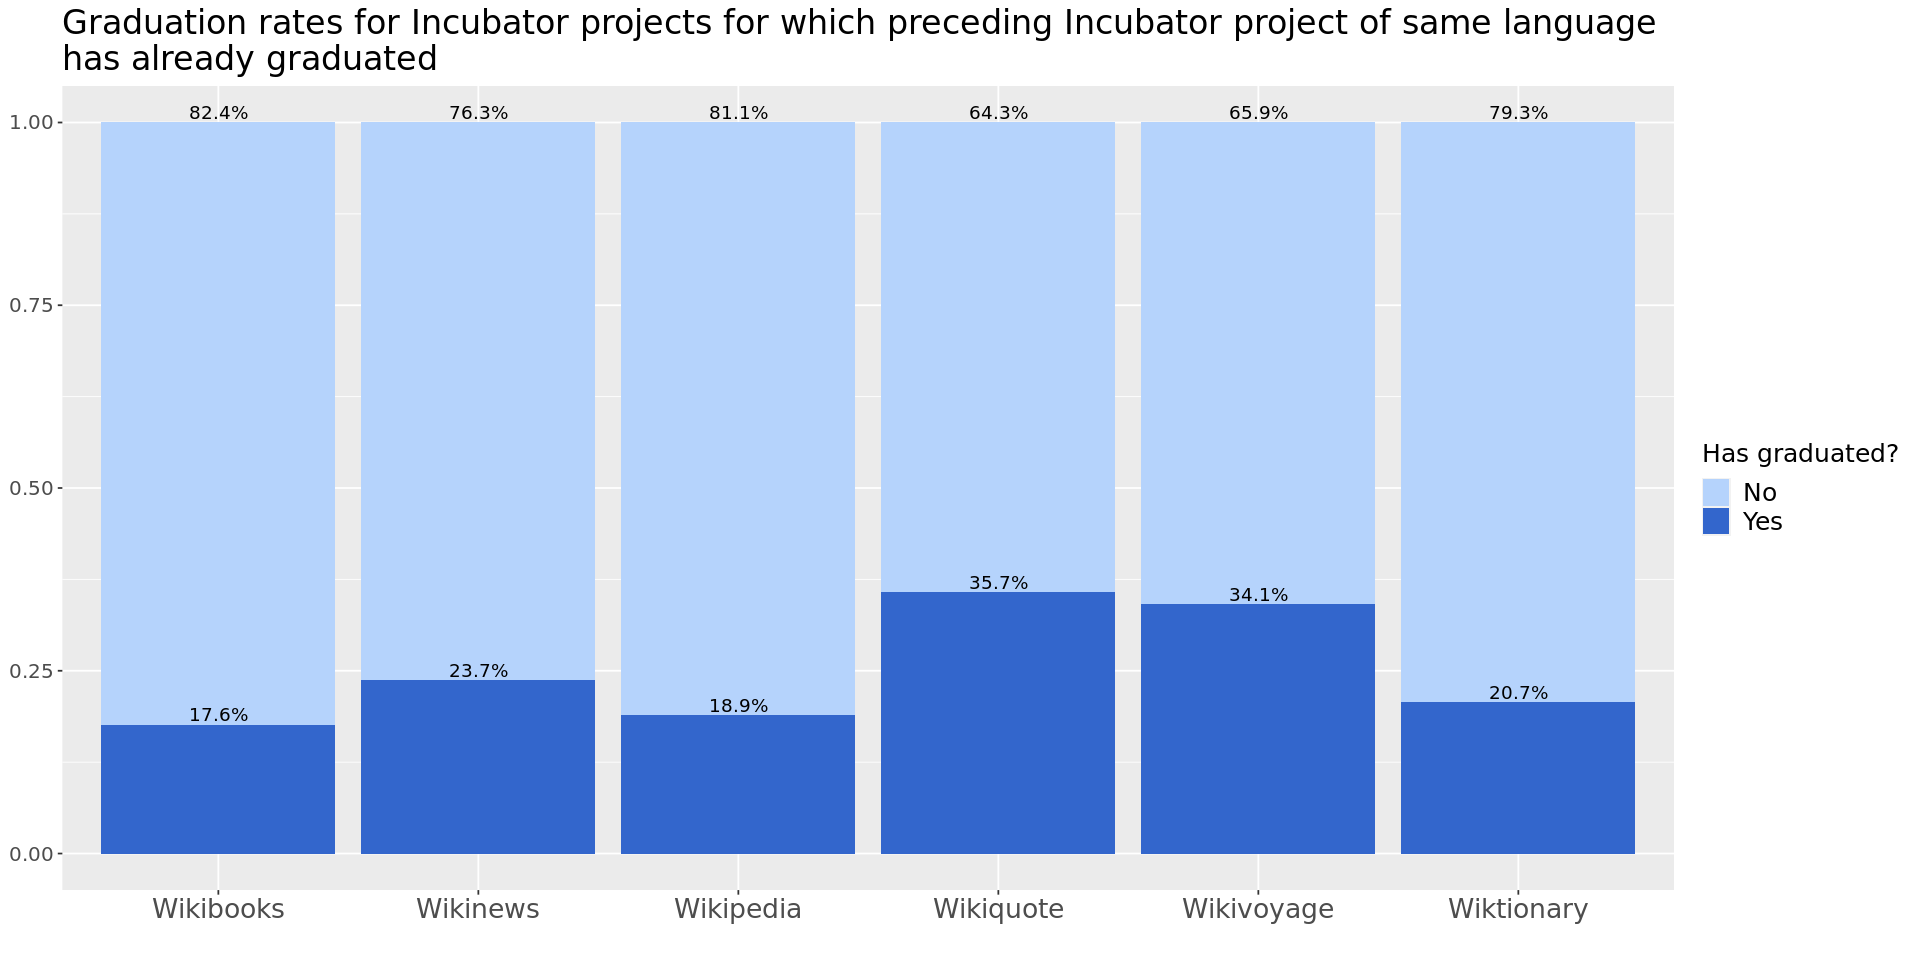

In [41]:
## PLOT 8A 
## Plot the graph above, but not broken down by sequential rank (i.e. Graduation rates for all languages' projects where prior project has graduated)
ftgoc_ranked %>% filter(prev_proj_grad=="Yes" | is.na(prev_proj_grad)) %>%
  ggplot(aes(x=project, fill=grad_yn)) +
  geom_bar(position="fill") +
  geom_text(aes(x = project, 
                label = scales::percent(after_stat(count / tapply(count, x, sum)[x])), 
                group = grad_yn), position = "fill", stat = "count", vjust=-0.25)  +
  labs(title = "Graduation rates for Incubator projects for which preceding Incubator project of same language \nhas already graduated") +
  xlab('') +
  guides(fill=guide_legend(title="Has graduated?")) +
  theme(plot.title = element_text(size=20), axis.title.x = element_text(size=15),  axis.title.y = element_blank(), 
        axis.text.y = element_text(size=12), axis.text.x = element_text(size=16), 
        legend.title=element_text(size=15), legend.text=element_text(size=15)) +
  scale_fill_manual(values = c( "#B5D3FC", "#3366cc")) 

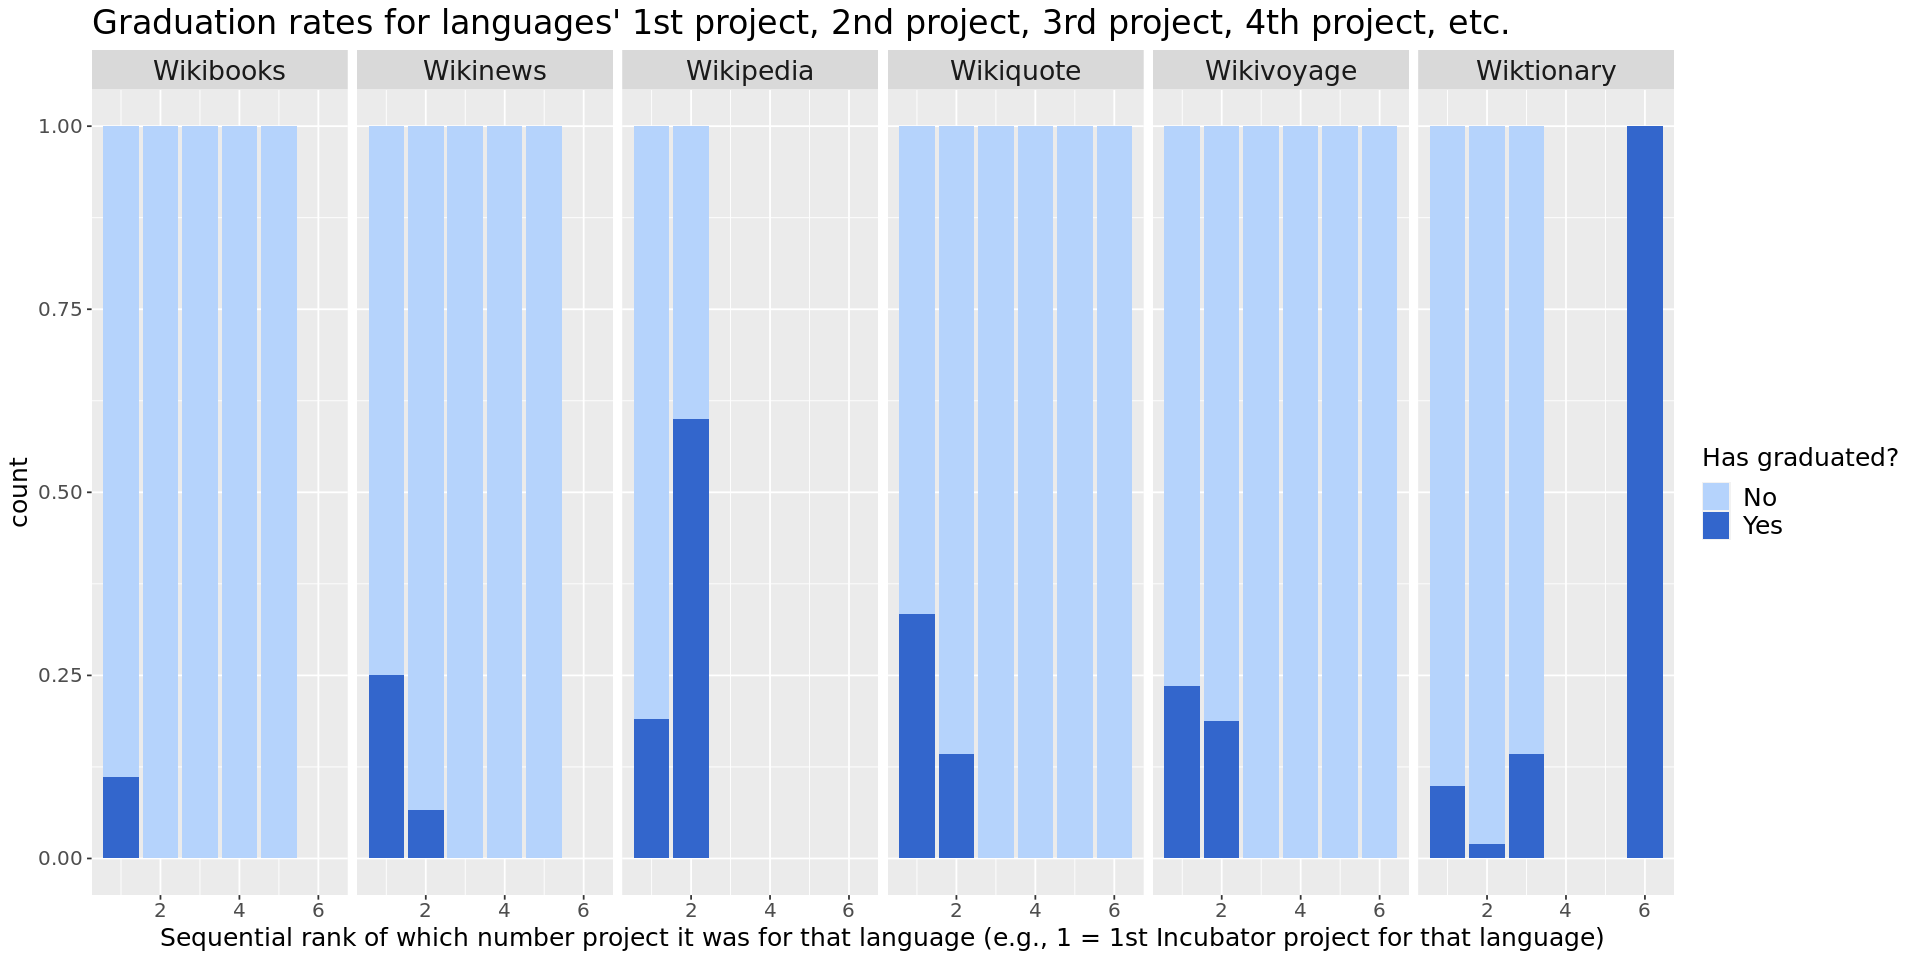

In [42]:
## PLOT 7B
## Plot Graduation rates for languages' 1st projects, 2nd projects if prev NOT graduated, 3rd projects if prev NOT graduated, etc.
ftgoc_ranked %>% filter(prev_proj_grad=="No" | is.na(prev_proj_grad)) %>%
  ggplot(aes(x=id, fill=grad_yn)) +
  geom_bar(position="fill") +
  facet_grid(.~project) +
  labs(title = "Graduation rates for languages' 1st project, 2nd project, 3rd project, 4th project, etc.") +
  guides(fill=guide_legend(title="Has graduated?")) +
  xlab('Sequential rank of which number project it was for that language (e.g., 1 = 1st Incubator project for that language)') +
  theme(plot.title = element_text(size=20), axis.title = element_text(size=15), axis.text = element_text(size=12), 
        legend.title=element_text(size=15), legend.text=element_text(size=15), strip.text=element_text(size=16)) +
  scale_fill_manual(values = c( "#B5D3FC", "#3366cc")) 

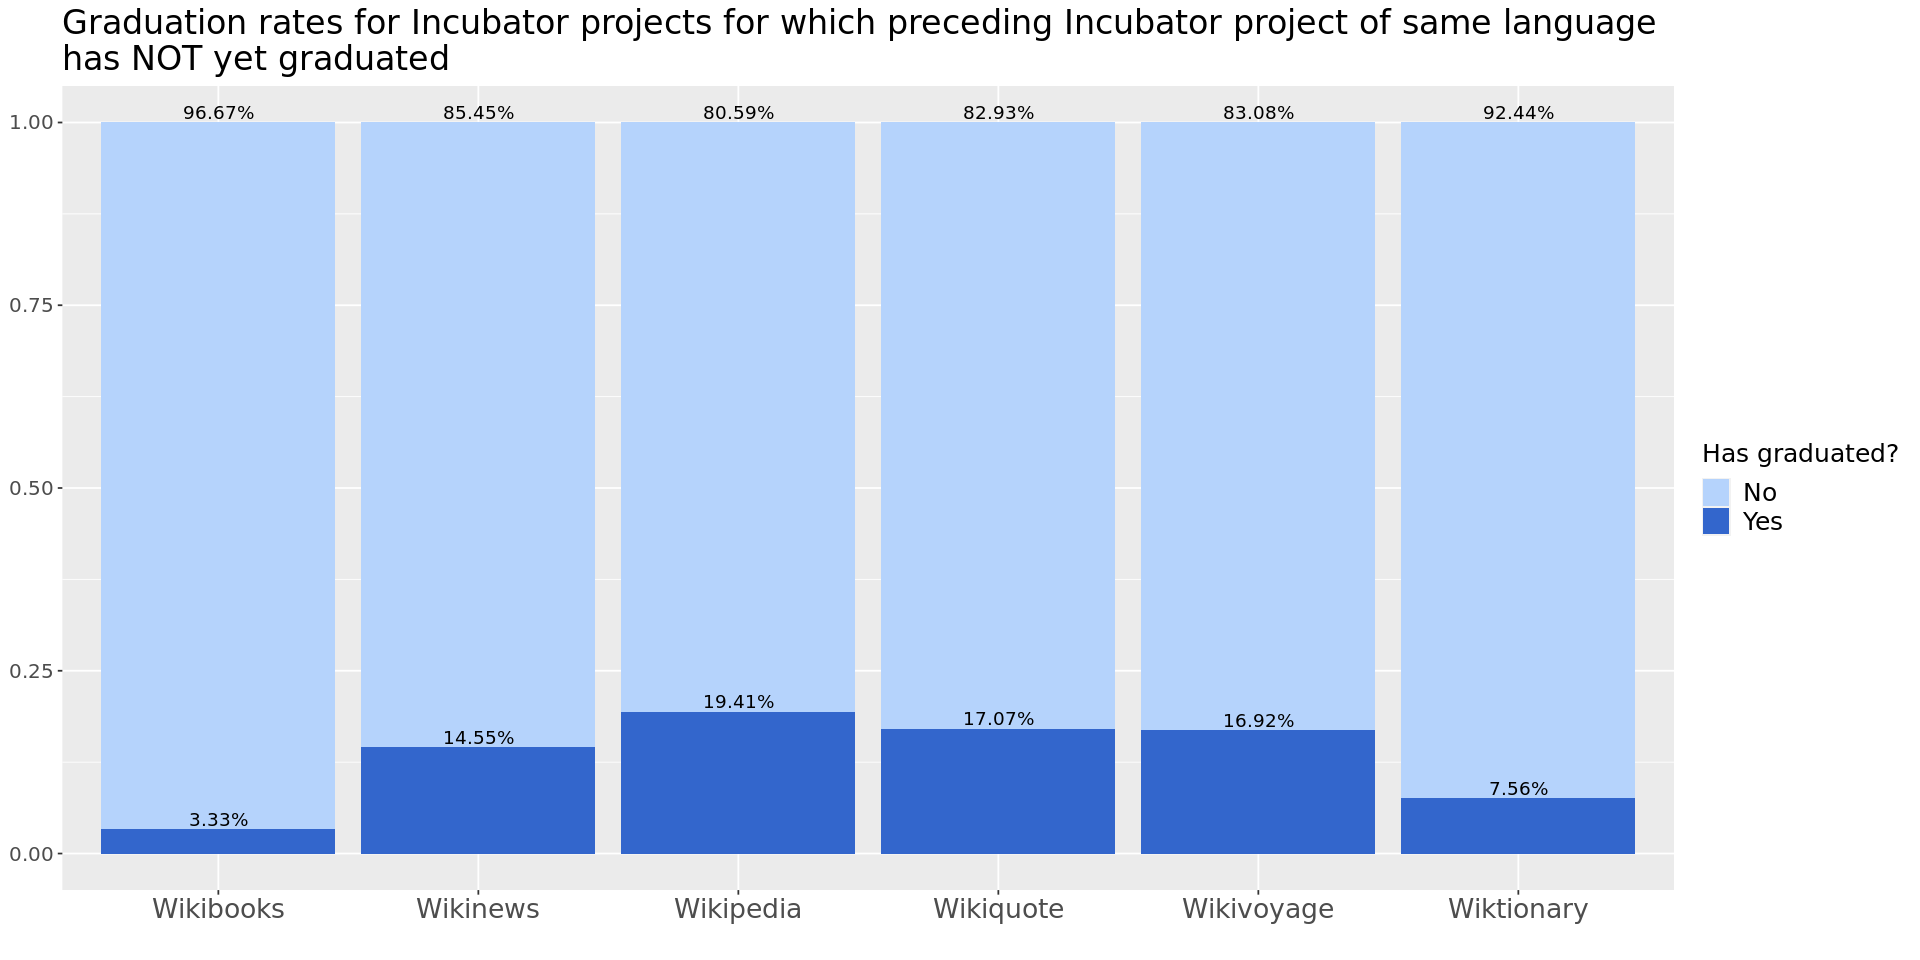

In [43]:
## PLOT 8B
## Plot the graph above, but not broken down by sequential rank (i.e., Graduation rates for all languages' projects where prior project has NOT graduated)
ftgoc_ranked %>% filter(prev_proj_grad=="No" | is.na(prev_proj_grad)) %>%
  ggplot(aes(x=project, fill=grad_yn)) +
  geom_bar(position="fill") +
  geom_text(aes(x = project, 
                label = scales::percent(after_stat(count / tapply(count, x, sum)[x])), 
                group = grad_yn), position = "fill", stat = "count", vjust=-0.25)  +
  labs(title = "Graduation rates for Incubator projects for which preceding Incubator project of same language \nhas NOT yet graduated") +
  xlab('') +
  guides(fill=guide_legend(title="Has graduated?")) +
  theme(plot.title = element_text(size=20), axis.title.x = element_text(size=15),  axis.title.y = element_blank(), 
        axis.text.y = element_text(size=12), axis.text.x = element_text(size=16), 
        legend.title=element_text(size=15), legend.text=element_text(size=15)) +
  scale_fill_manual(values = c( "#B5D3FC", "#3366cc")) 

## Analyses of language's 1st project

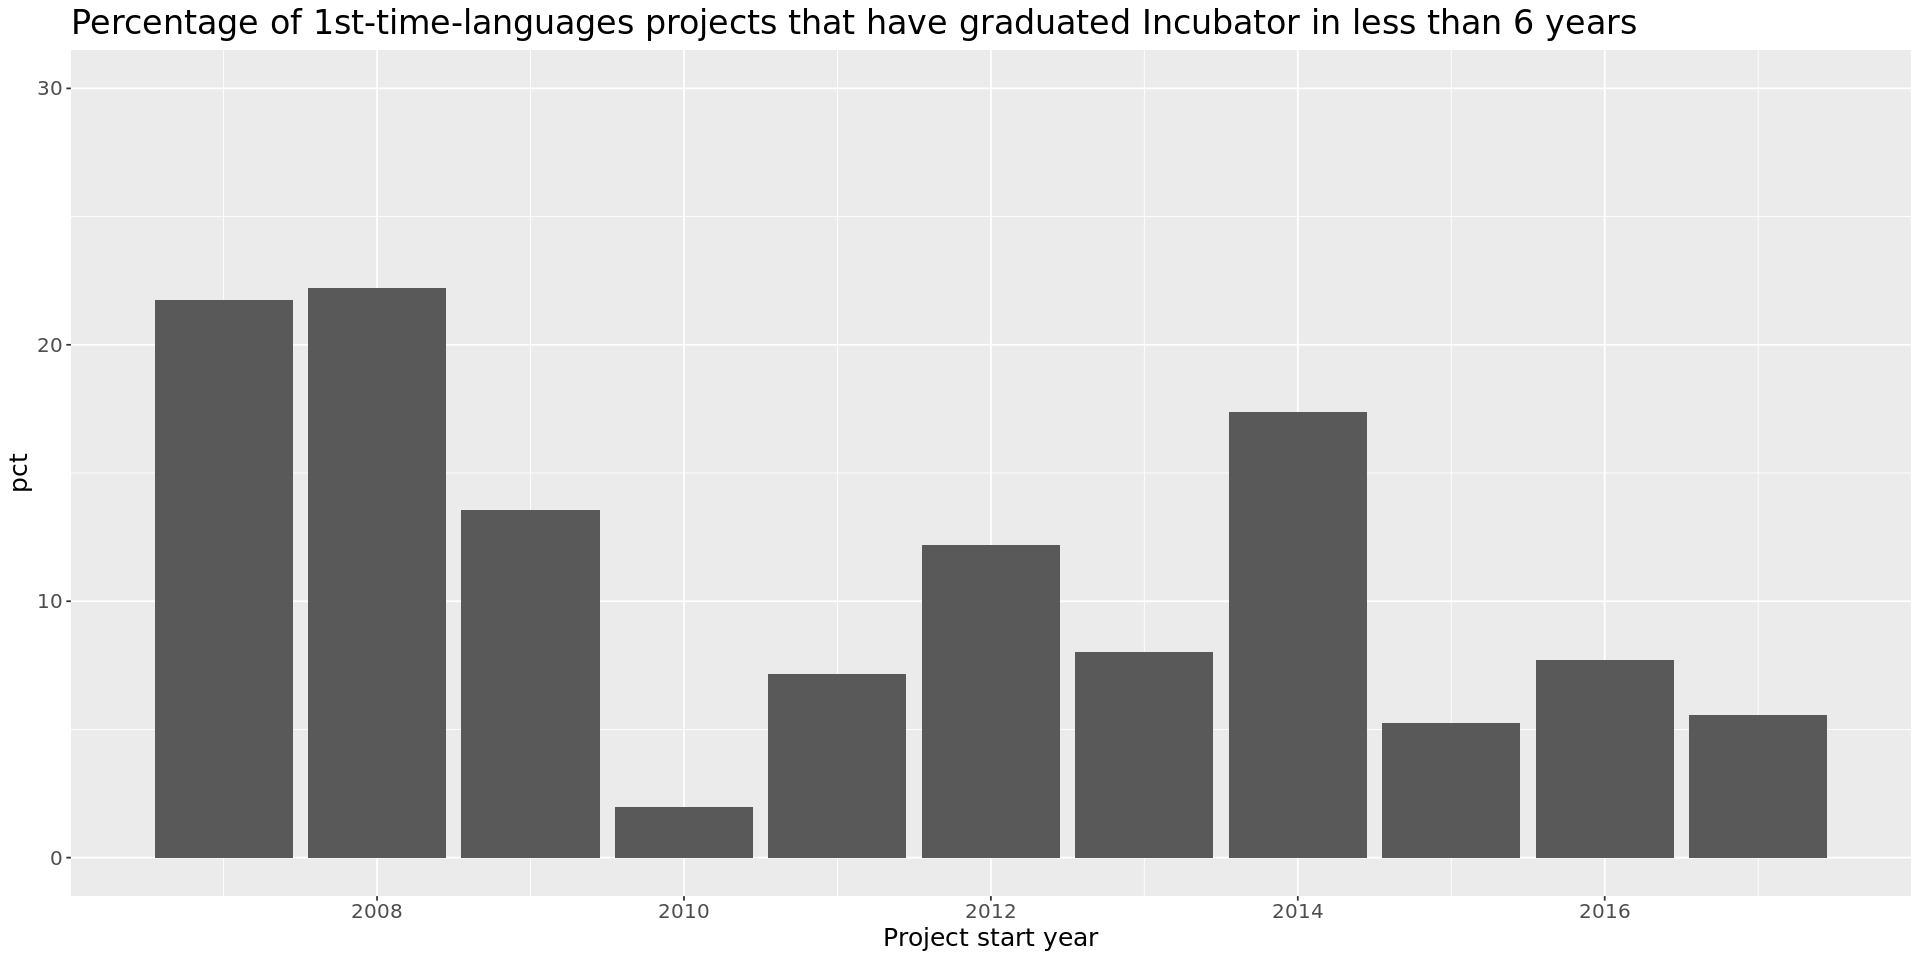

In [44]:
## PLOT 9 
## Plot Percentage of 1st-time-languages projects graduated Incubator in < 6 years
options(repr.plot.width=16, repr.plot.height=08)

moe_crosstab(df=(ftgoc_ranked %>% filter(id==1)), 
             x=first_edit_year, y=grad_less_6, weight=weight) %>%
  filter(grad_less_6 == "Yes") %>%
  filter(first_edit_year > 2006) %>% # exclude 2006 because very different at that time
  filter(first_edit_year < 2018) %>% # exclude 2019 and later because we haven't had a full 6 years for all those
  ggplot(aes(x=first_edit_year, y=pct)) +
  geom_bar(stat="identity") +
  labs(title = "Percentage of 1st-time-languages projects that have graduated Incubator in less than 6 years") +
  xlab('Project start year') +
  theme(plot.title = element_text(size=20), axis.title = element_text(size=15), axis.text = element_text(size=12))+
  ylim(0, 30)

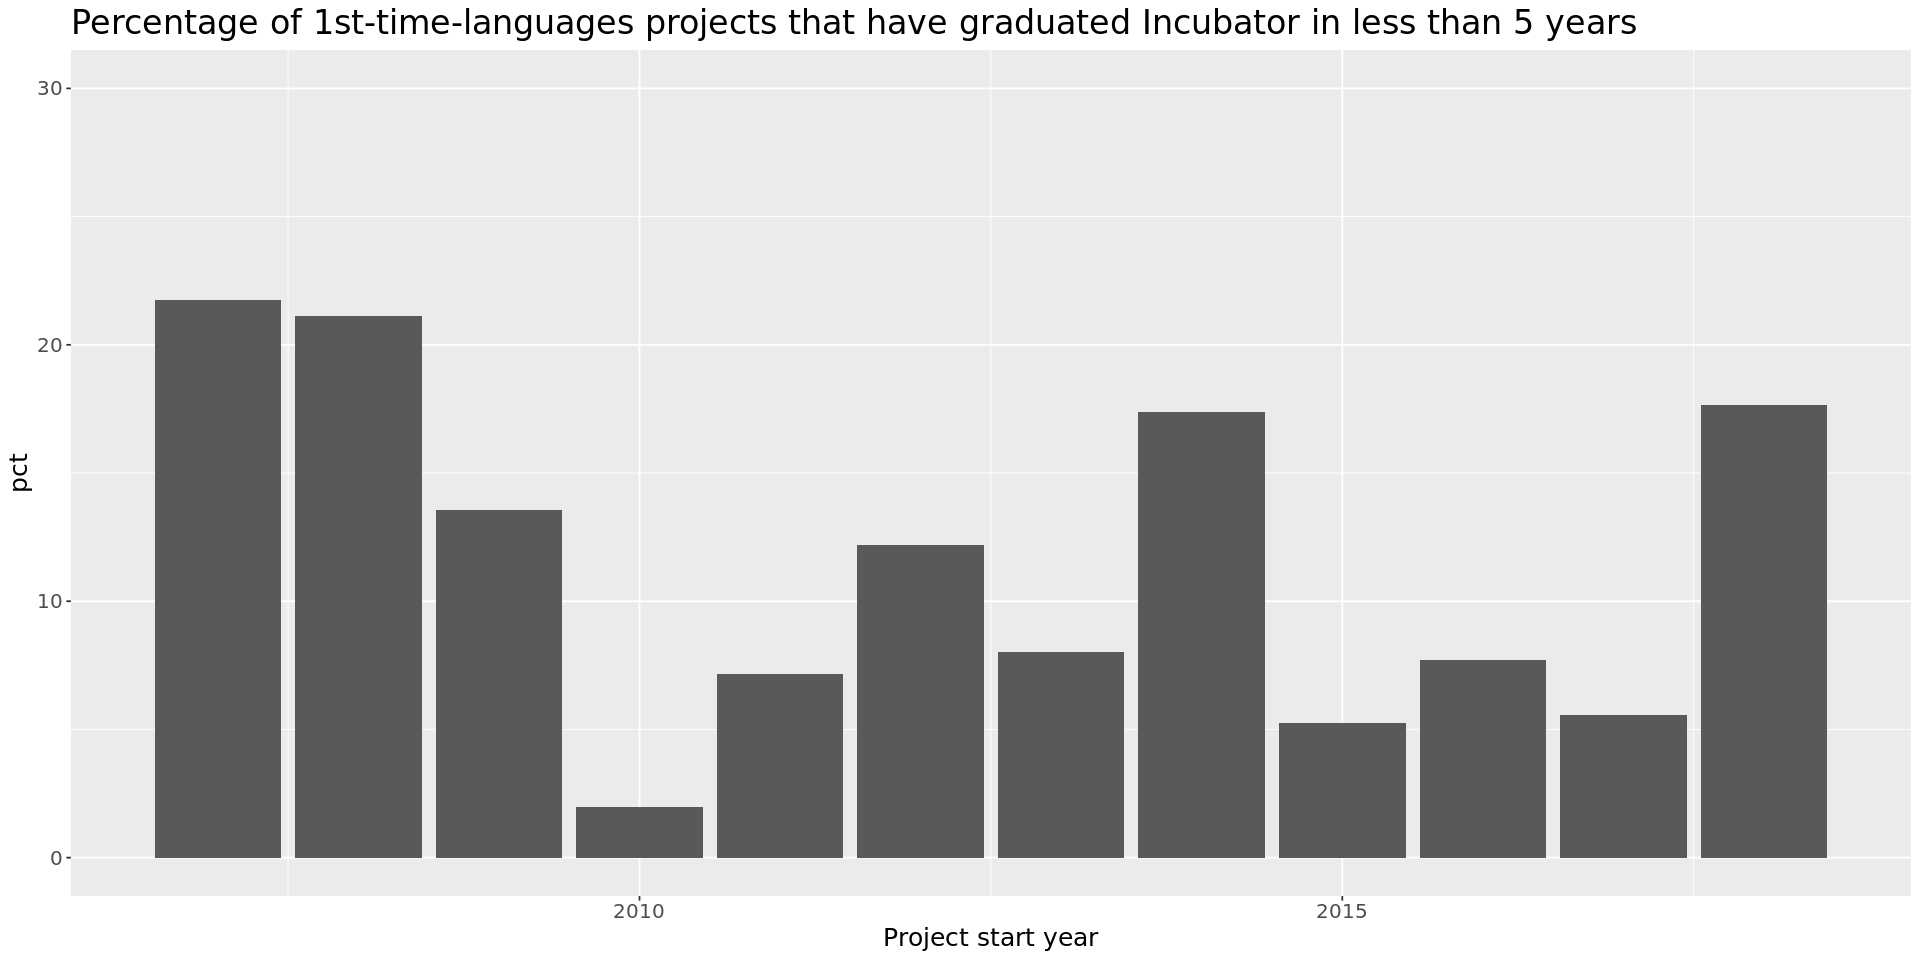

In [45]:
## PLOT 10
## Plor Percentage of 1st-time-languages projects graduated Incubator in < 5 years
options(repr.plot.width=16, repr.plot.height=08)

moe_crosstab(df=(ftgoc_ranked %>% filter(id==1)), 
             x=first_edit_year, y=grad_less_5, weight=weight) %>%
  filter(grad_less_5 == "Yes") %>%
  filter(first_edit_year > 2006) %>% # exclude 2006 because very different at that time
  filter(first_edit_year < 2019) %>% # exclude 2019 and later because we haven't had a full 5 years for all those
  ggplot(aes(x=first_edit_year, y=pct)) +
  geom_bar(stat="identity") +
  labs(title = "Percentage of 1st-time-languages projects that have graduated Incubator in less than 5 years") +
  xlab('Project start year') +
  theme(plot.title = element_text(size=20), axis.title = element_text(size=15), axis.text = element_text(size=12))+
  ylim(0, 30)